# **Health Insurance Cross Sell Prediction**

## **Import libraries and modules**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             accuracy_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay)

# from modules.utils import Utils
from modules.categorical_analysis import CategoricalAnalyses
from modules.numerical_analysis import NumericalAnalyses
from modules.feature_engineering import FeatureEngineering
from modules.feature_selection import FeatureSelection
from modules.data_augmentation import Augmentation
from modules.data_undersampling import Undersampling
# from modules.modeling import Modeling

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Silent Pandas downcasting warning 
pd.set_option('future.no_silent_downcasting', True)

c:\Users\hugot\anaconda3\envs\health_insurance_cross_sell_prediction\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Collect data**

In [2]:
# Load DataFrame directly from GitHub Repo
df_train_original = pd.read_csv('https://raw.githubusercontent.com/HugoTex98/Health-Insurance-Cross-Sell-Prediction/main/dataset/dataset.csv')
df_train_original

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [3]:
df_train_original["id"].value_counts()

id
1         1
254071    1
254080    1
254079    1
254078    1
         ..
127035    1
127034    1
127033    1
127032    1
381109    1
Name: count, Length: 381109, dtype: int64

The test dataset doesn't have the target (`Response`) in it, so we can´t use it . <br><br>
We'll use the train dataset to split between train and test datasets!

There are **no repeated ID's** in the train dataset, which means that we can split into train and test without concernings about clients' overlap in both datasets. <br>
Let's use `stratify` from `train_test_split` to ensure equal percentage of our target (`Response`) in both training and test datasets. 

In [4]:
df_train, df_test = train_test_split(df_train_original, test_size=0.20, random_state=42, stratify=df_train_original["Response"])



Let's see how many examples there are in train dataset, and the number of our target `Response` classes:

In [5]:
print(f"No. of training examples: {df_train.shape[0]}")
print(f'Training set has: \n {df_train["Response"].value_counts()}')
print(f"Training set % of positive Response: {(len(df_train[df_train["Response"] == 1]) /
                                               df_train.shape[0]) *
                                               100}")

print(f"\nNo. of testing examples: {df_test.shape[0]}")
print(f'Test set has: \n {df_test["Response"].value_counts()}')
print(f"Test set % of positive Response: {(len(df_test[df_test["Response"] == 1]) /
                                           df_test.shape[0]) *
                                           100}")

No. of training examples: 304887
Training set has: 
 Response
0    267519
1     37368
Name: count, dtype: int64
Training set % of positive Response: 12.256344153735647

No. of testing examples: 76222
Test set has: 
 Response
0    66880
1     9342
Name: count, dtype: int64
Test set % of positive Response: 12.256303954238934


In [6]:
df_test = df_test.drop(columns=["id"]).reset_index(drop=True)
df_test

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,54,1,28.0,0,> 2 Years,Yes,75219.0,26.0,53,1
1,Female,26,1,3.0,0,1-2 Year,Yes,19738.0,156.0,280,0
2,Male,25,1,28.0,0,< 1 Year,Yes,61524.0,124.0,255,0
3,Male,29,1,24.0,0,1-2 Year,Yes,2630.0,157.0,235,1
4,Female,28,1,28.0,0,< 1 Year,Yes,51473.0,26.0,243,1
...,...,...,...,...,...,...,...,...,...,...,...
76217,Male,40,1,28.0,0,1-2 Year,Yes,32747.0,124.0,140,0
76218,Female,39,1,48.0,0,1-2 Year,No,2630.0,124.0,178,0
76219,Male,60,1,28.0,0,1-2 Year,Yes,36965.0,26.0,285,0
76220,Male,23,1,15.0,1,< 1 Year,No,28270.0,152.0,98,0


## **Data Understanding**

Here, we'll focus on gaining an initial grasp of the dataset by analyzing its structure and quality. This involves:

 - **Missing Values Analysis:** Identifying the presence of any missing values and assessing their potential impact on the analysis and model building.
 - **Descriptive Statistics:** Summarizing key metrics such as mean, median, variance, and distribution of numerical and categorical features to provide insight into their central tendencies and spread.
 - **Distribution Analysis:**
    - For numerical columns: Exploring their distribution using histograms, box plots, and other visualizations to detect outliers or skewness.
    - For categorical columns: Reviewing the frequency distribution of categories and identifying any imbalances.

### General Exploration

Let's take a look at dataset's missing values and columns dtypes:

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304887 entries, 274710 to 221791
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    304887 non-null  int64  
 1   Gender                304887 non-null  object 
 2   Age                   304887 non-null  int64  
 3   Driving_License       304887 non-null  int64  
 4   Region_Code           304887 non-null  float64
 5   Previously_Insured    304887 non-null  int64  
 6   Vehicle_Age           304887 non-null  object 
 7   Vehicle_Damage        304887 non-null  object 
 8   Annual_Premium        304887 non-null  float64
 9   Policy_Sales_Channel  304887 non-null  float64
 10  Vintage               304887 non-null  int64  
 11  Response              304887 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 30.2+ MB


From the output above, it is possible to see that there are **no missing values** in the training dataset, having 3 different dtypes. <br><br>
We'll observe a statistical summary of the dataset numerical columns below:

In [8]:
df_train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000
mean,190738.657112,38.826897,0.997855,26.396239,0.458127,30591.308311,112.053859,154.392214,0.122563
std,110004.367239,15.515299,0.046265,13.228749,0.498244,17239.285689,54.189288,83.670312,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95504.500000,25.000000,1.000000,15.000000,0.000000,24403.000000,29.000000,82.000000,0.000000
50%,190886.000000,36.000000,1.000000,28.000000,0.000000,31697.000000,134.000000,154.000000,0.000000
75%,285863.500000,49.000000,1.000000,35.000000,1.000000,39443.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [9]:
# store numerical columns
num_cols = df_train.select_dtypes(include=['int', 'float']).columns.tolist()

The columns `Driving_License` and `Previously_Insured` are binary, indicating whether a client has driving license or if was previously insured in a past accident, respectively. <br><br>
Let's take a look at the categorical columns:

In [10]:
# store categorical columns
cat_cols = df_train.select_dtypes(include='object').columns.tolist()
cat_cols

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [11]:
df_train[cat_cols].describe()

,Gender,Vehicle_Age,Vehicle_Damage
count,304887,304887,304887
unique,2,3,2
top,Male,1-2 Year,Yes
freq,164780,160195,153959


In [12]:
print("Gender classes: ", df_train['Gender'].unique())
print("Vehicle Age classes: ", df_train['Vehicle_Age'].unique())
print("Vehicle Damage classes: ", df_train['Vehicle_Damage'].unique())

Gender classes:  ['Male' 'Female']
Vehicle Age classes:  ['< 1 Year' '1-2 Year' '> 2 Years']
Vehicle Damage classes:  ['Yes' 'No']


### Numerical Features Analysis

In [13]:
# instatiate NumericalAnalyses class for these analysis
num_analysis = NumericalAnalyses(df_train[num_cols])

In [14]:
num_cols

['id',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response']

Since `Driving_License`, `Previously_Insured`, and `Response` (our target) are binary variables, we'll observe their distributions jointly with the Categorical features. <br><br>
The `id ` column is not used for any of these explorations. 

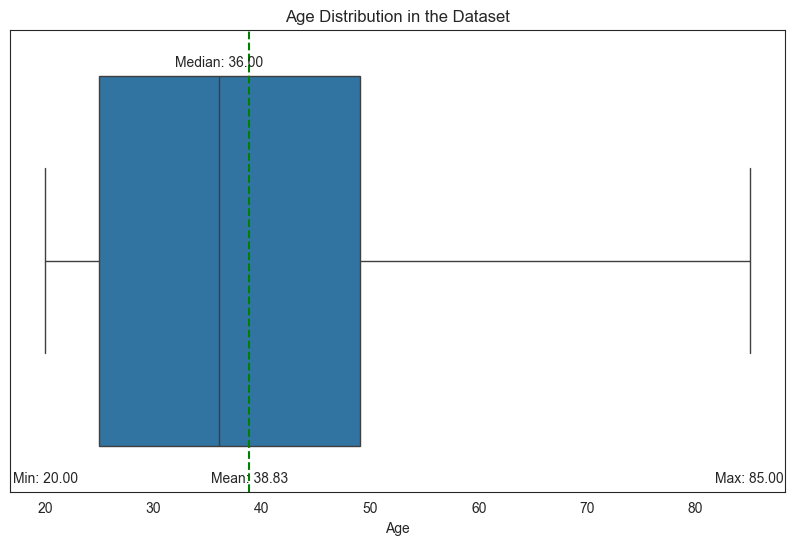

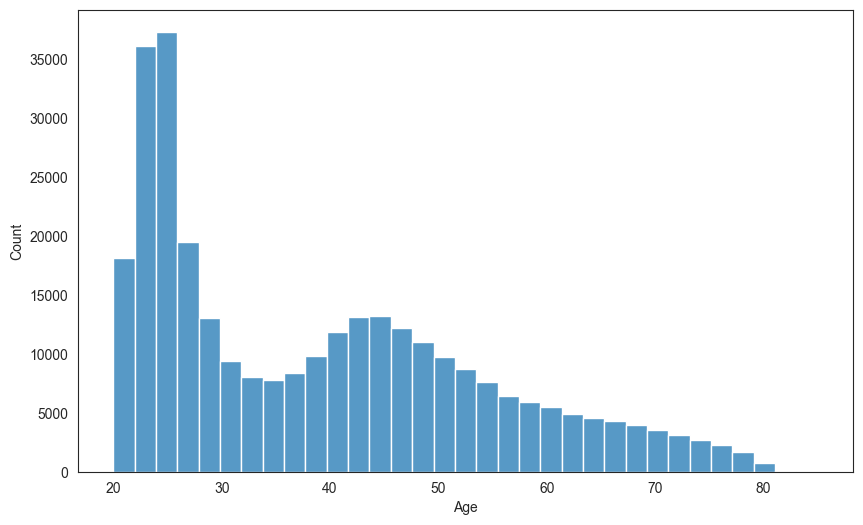

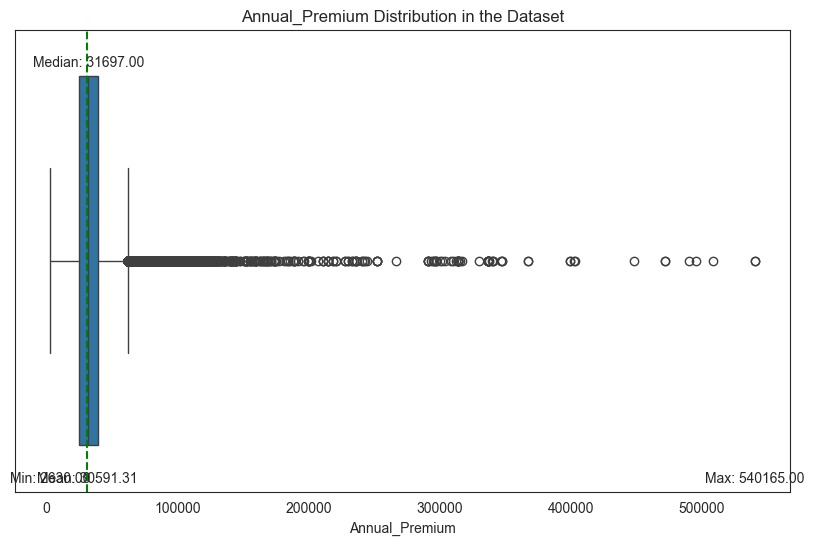

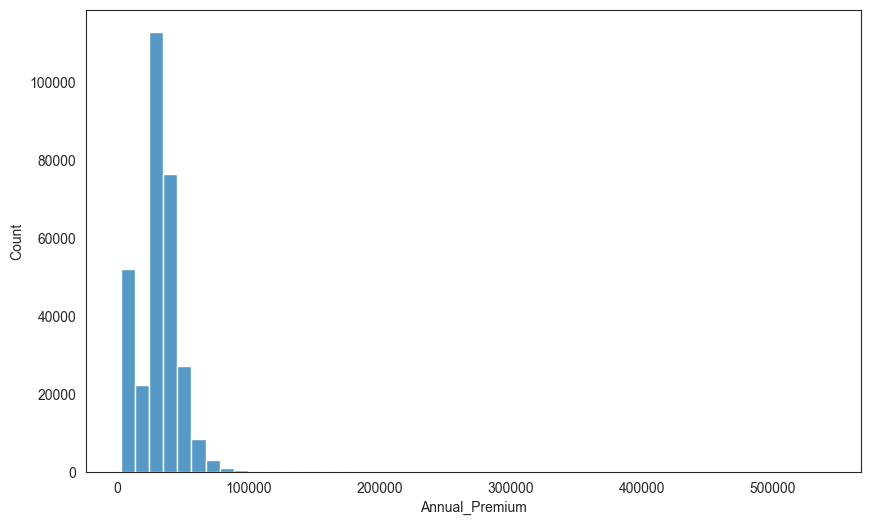

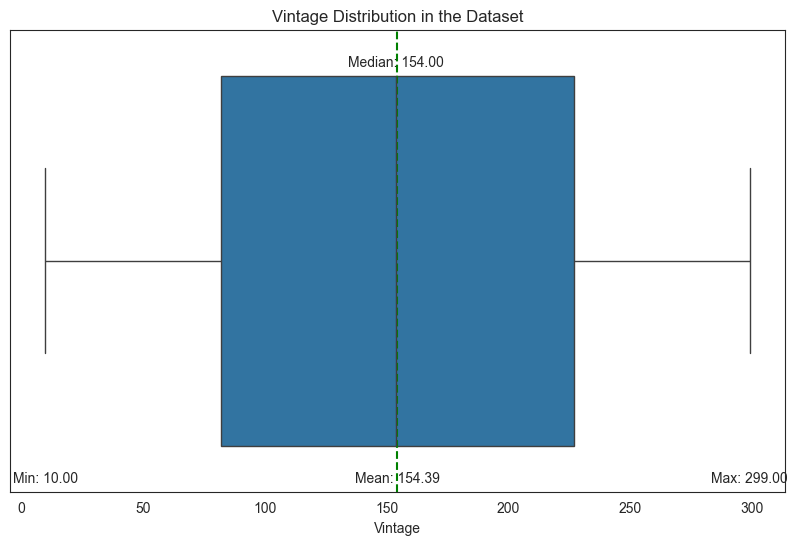

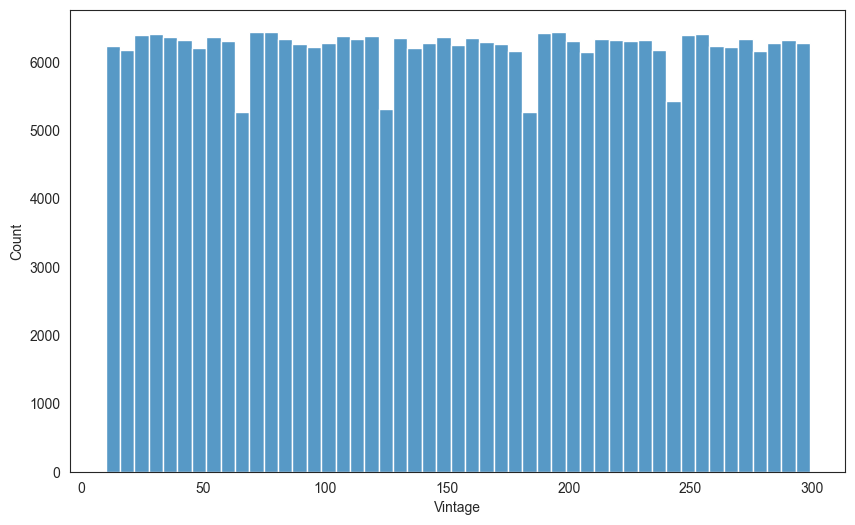

In [15]:
for col in ['Age', 'Annual_Premium', 'Vintage']:
    num_analysis.boxplots(col)
    num_analysis.hist(col)

From the box plot's above, we can see that the variables `Age` and `Vintage` have distributions relatively symmetrical, with the `Age` varible having a slight right (positive) skewness (mean greater than median), indicating more client with higher ages. <br><br>
On the other hand, the `Annual_Premium` has higher number of outliers, reflecting the discrepancy in premiums applied by each client. It needs to be analyzed further to address these outliers.    

The `Region_Code` and `Policy_Sales_Channel` will be explored through bar plots:

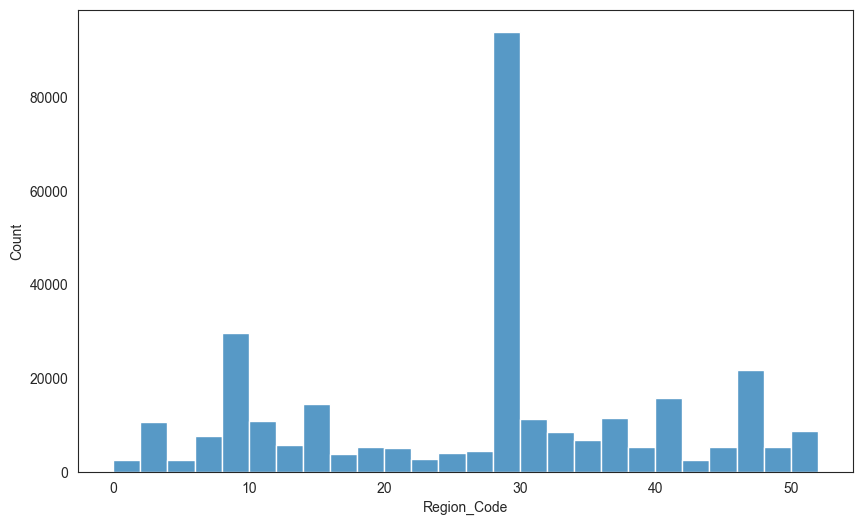

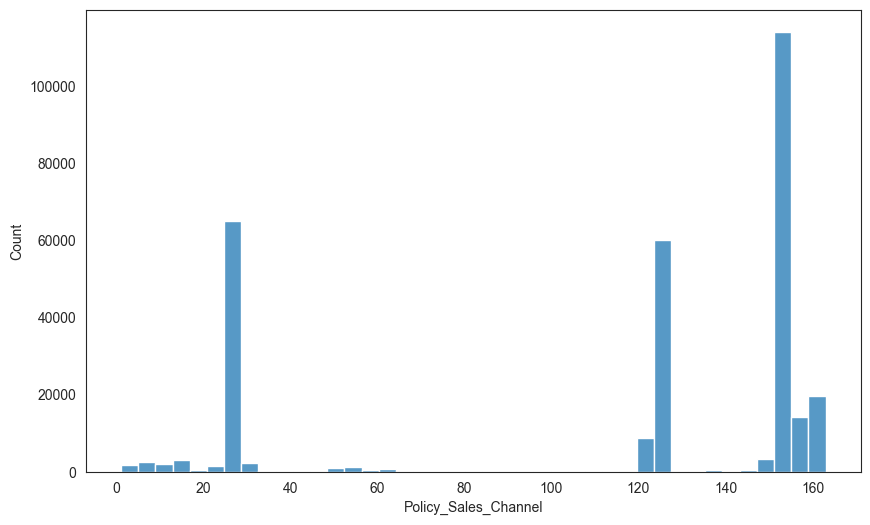

In [16]:
for col in ['Region_Code', 'Policy_Sales_Channel']:
    num_analysis.hist(col)

### Categorical Features Analysis

In [17]:
cat_analysis = CategoricalAnalyses(df_train)

In [18]:
cat_cols

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

Let's explore the distributions of the Categorical features above, along with the features that are not as `object` type in the DataFrame but are binary: `Driving_License`, `Previously_Insured`.

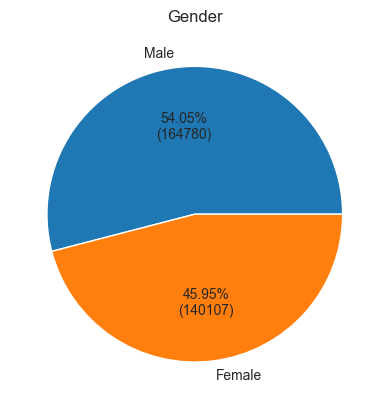

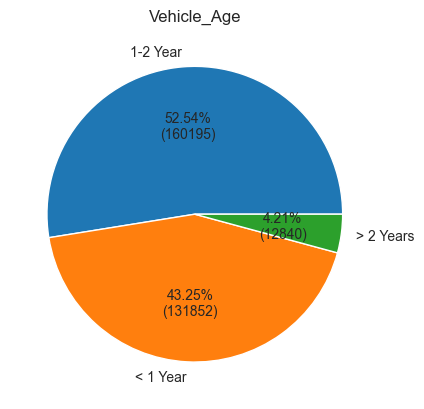

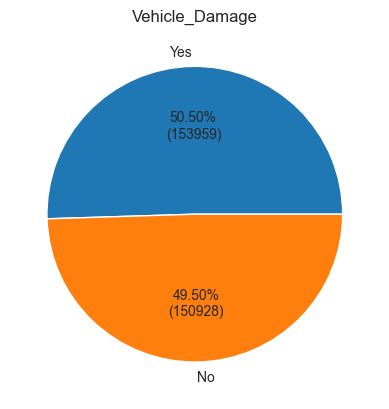

In [19]:
cat_analysis.pie(cat_cols)

From the pie charts above, can conclude:

- There are slightly more Males than Females;
- Approximately 96% of the health insured clients have a **car with or less than 2 years**;
- There's an equal proportion of clients who have suffered an accident and those who have not;
- Only 0.21% of the clients **do not possess driving license**;
- There are slightly more clients that have been previously insured than those who have never been.

## **Data Exploration**

We will explore and analyze the relationships between the dataset's variables and the target variable, "Response". This will include:

 - **Bivariate and Multivariate Analysis:** Investigating the relationships between independent variables and the target variable, identifying correlations, and potential interactions.
 - **Visualizations:** Utilizing plots like histograms, bar charts, scatter plots, and heatmaps to visually understand patterns and correlations.
 - **Statistical Tests:** Conducting tests such as chi-square, ANOVA, or t-tests to evaluate the significance of relationships between variables.

This analysis will allow us to have a better understanding of our clients profile. 

### **Categorical Variables**

#### Response vs Gender

Starting to understand how the `Gender` can be important in acquiring an Vehicle Insurance (when our target `Response` is 1).  

In [20]:
# Group the data by Gender and Response and count the occurrences
gender_resp = df_train.groupby(['Gender', 
                                'Response'])['id'] \
                                    .count().to_frame() \
                                        .rename(columns={'id': 'count'}) \
                                            .reset_index()

gender_resp["Response"] = gender_resp["Response"].replace({0:"No", 1:"Yes"}) 
gender_resp

,Gender,Response,count
0,Female,No,125490
1,Female,Yes,14617
2,Male,No,142029
3,Male,Yes,22751


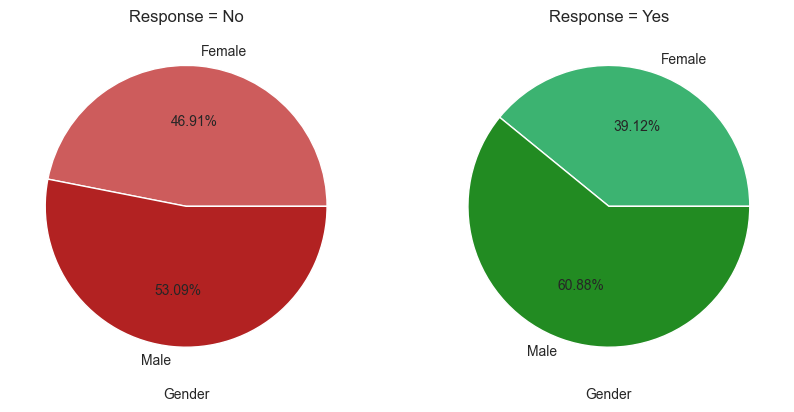

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Loop over the Response categories and plot the data for each Gender category
for i, response in enumerate(gender_resp['Response'].unique()):
    data = gender_resp[gender_resp['Response'] == response]
    ax = axs[i]
    color = ["indianred","firebrick"] if response == "No" else ["mediumseagreen", "forestgreen"]
    ax.pie(data['count'], labels=data['Gender'], colors=color, autopct='%1.2f%%')
    ax.set_title(f"Response = {response}")
    ax.set_xlabel('Gender')

plt.show()

In the `Response = 1` is evidently that Male clients are more interested in acquiring an Vehicle Insurance. This might be due to several reasons, for example, usually Male drivers are more prone to accidents because they have a more agressive driving. 
<br>
It is important to mention, from the initial distribution analysis on `Gender`, that we have around 8% more Males (164780) than Females (140107).
<br><br>
Let's explore that. 

#### Vehicle Damage and Responses

In [22]:
gender_damage = df_train[df_train["Response"] == 1].groupby(['Gender',
                                                              'Vehicle_Damage'])['id'] \
                                                                .count().to_frame() \
                                                                    .rename(columns={'id': 'count'}) \
                                                                        .reset_index()

gender_damage

,Gender,Vehicle_Damage,count
0,Female,No,331
1,Female,Yes,14286
2,Male,No,463
3,Male,Yes,22288


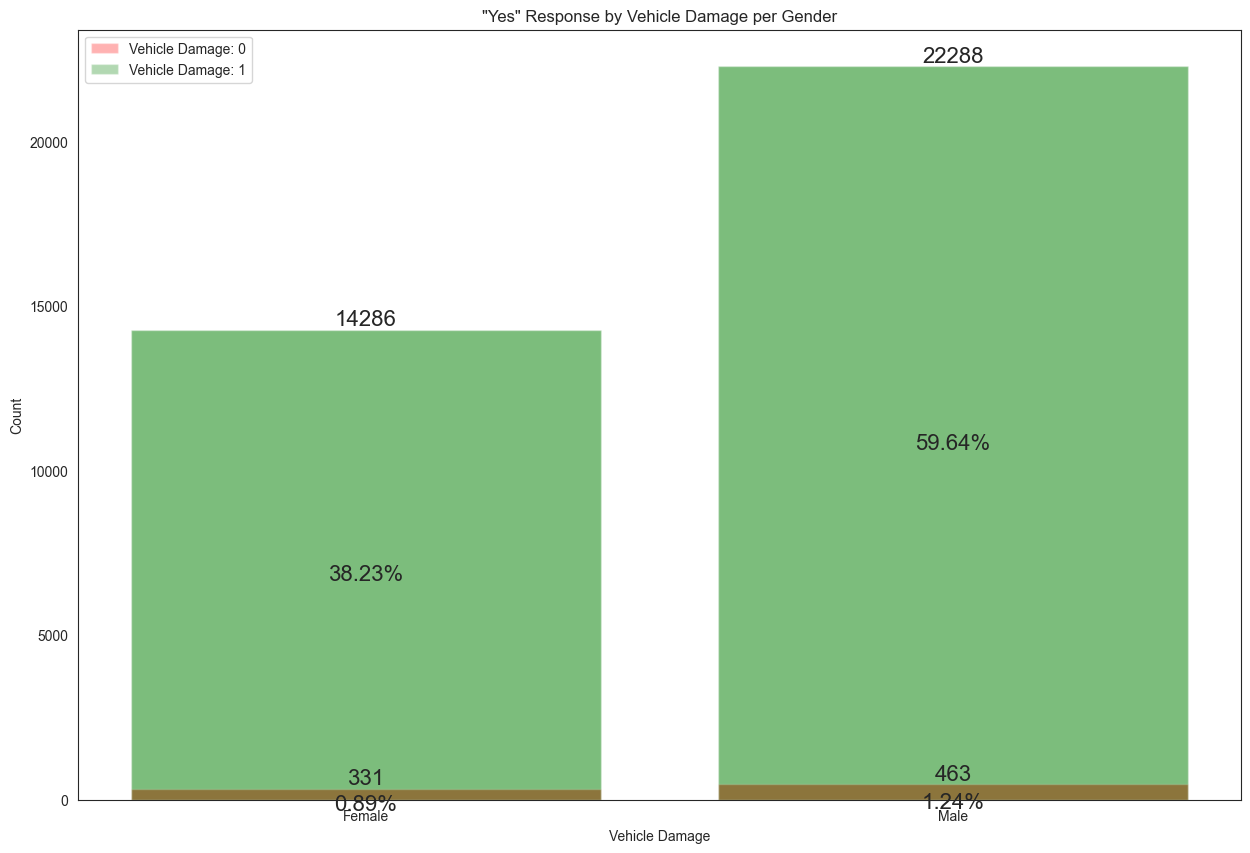

In [23]:
plt.figure(figsize=(15,10))
plt.bar(gender_damage['Gender'], 
        gender_damage['count'], color=['red', 
                                       'green'], 
                                       alpha=0.3)
plt.xlabel('Vehicle Damage')
plt.ylabel('Count')
plt.title('"Yes" Response by Vehicle Damage per Gender')
bars = plt.bar(gender_damage['Gender'], 
               gender_damage['count'], color=['red', 
                                              'green'], 
                                              alpha=0.3)

# Add count and percentage labels inside the bars
for bar in bars:
    height = bar.get_height()
    percentage = '{:.2f}%'.format((height / gender_damage['count'].sum()) * 100)
    count_label = str(int(height))
    plt.text(bar.get_x() + bar.get_width() / 2, height, count_label, ha='center', va='bottom', fontsize=16)
    plt.text(bar.get_x() + bar.get_width() / 2, height/2, percentage, ha='center', va='top',  fontsize=16)

plt.legend(bars, ['Vehicle Damage: 0', 'Vehicle Damage: 1'])
plt.show()

From the above bar plot it is possible to conclude than, no matter the `Gender`, having a **car accident in the past** is important for these clients to acquire Vehicle Insurance!

One factor that may contribute to more vehicle damage is the `Age` of the drivers. Young drivers can have more accidents since they're taking the first steps, together with older drivers, which can have more accidents due to aging, with problems in their attention, reflexes and vision. 
<br><br>

Let's see how the clients `Response` relates with their `Age` and `Vehicle_Damage`.

In [24]:
damage_age_resp = df_train.groupby(["Age",
                                    "Response"])["Vehicle_Damage"] \
                                    .count().to_frame("count").reset_index()

damage_age_resp["Response"] = damage_age_resp["Response"].replace({0:"No", 1:"Yes"})
damage_age_resp

,Age,Response,count
0,20,No,4817
1,20,Yes,134
2,21,No,12731
3,21,Yes,460
4,22,No,16143
...,...,...,...
125,82,Yes,1
126,83,No,14
127,83,Yes,1
128,84,No,10


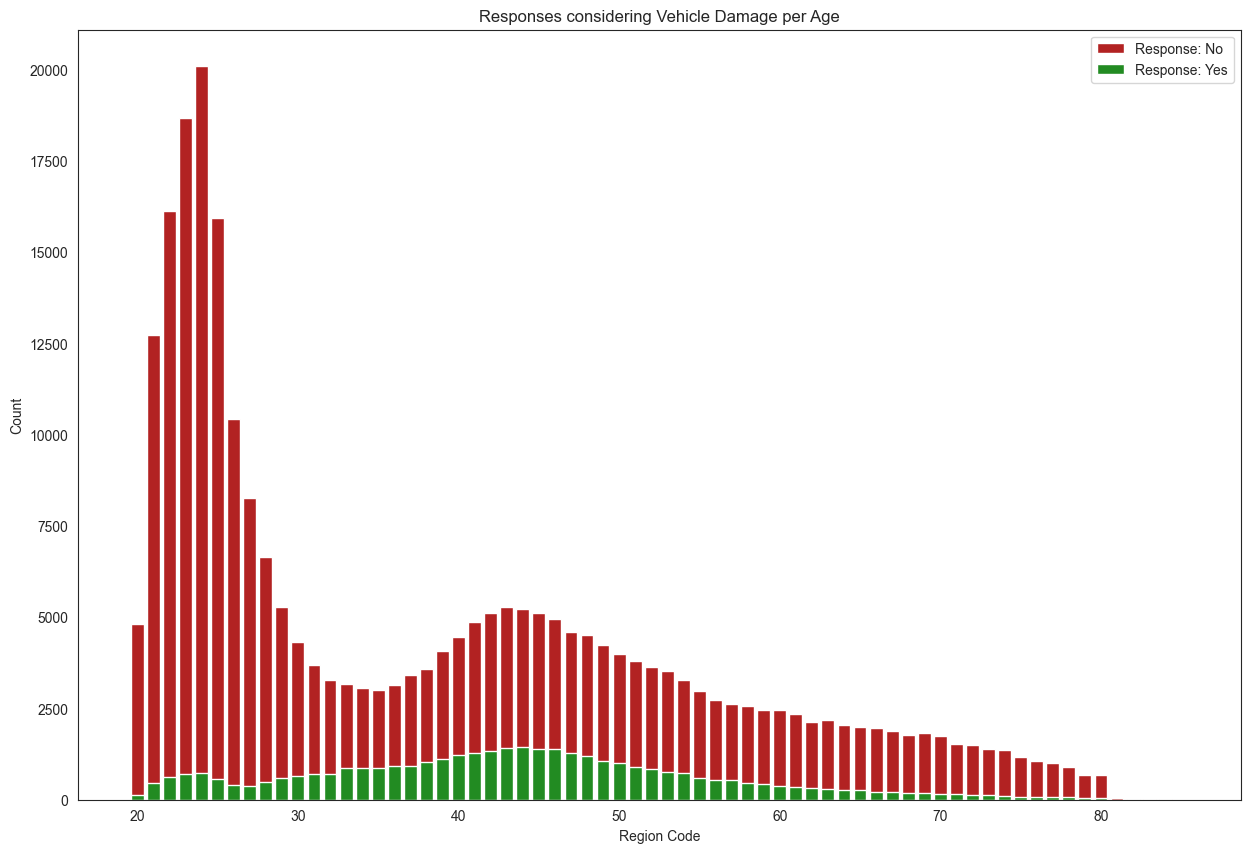

In [25]:
plt.figure(figsize=(15,10))
plt.xlabel('Region Code')
plt.ylabel('Count')
plt.title('Responses considering Vehicle Damage per Age')
stacked_bars = plt.bar(damage_age_resp['Age'], damage_age_resp['count'],
                       color=['firebrick', 'forestgreen']) # , alpha=0.6
plt.legend(stacked_bars, ['Response: No', 'Response: Yes'])
plt.show()

A large portion of the clients who report "No" `Vehicle_Damage` are in the younger age group (20 to 30 years old), indicating that this group either experience fewer accidents or are less likely to report accidents. After age 30, the count of "No" responses steadily decreases but remains significant across age groups until around age 60, where the counts begin to diminish sharply.
<br><br>

There appears to be a slight increase in the proportion of "Yes" responses after age 30, which may be related to more experienced drivers having more accidents or have a finantial stability to have an insurance.

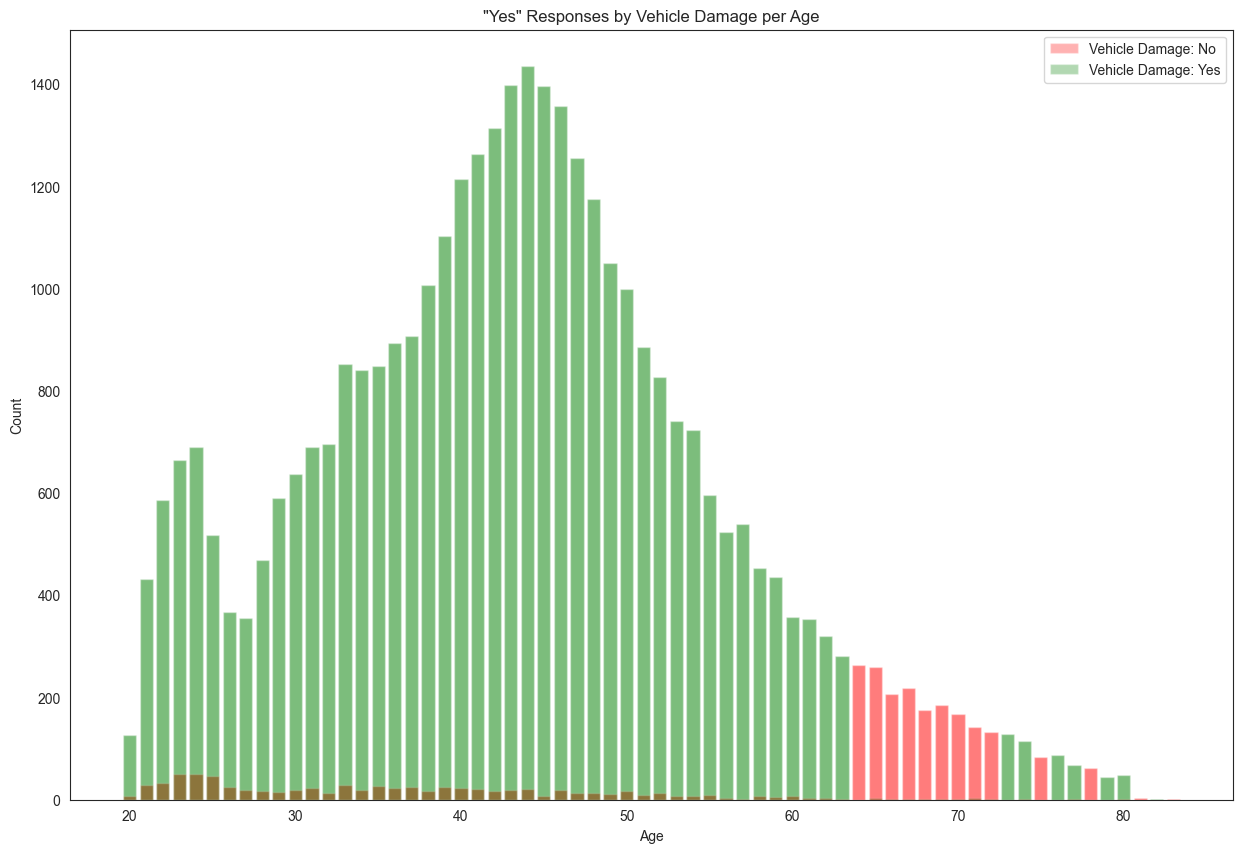

In [26]:
age_damage = df_train[df_train["Response"] == 1].groupby(['Age',
                                                          'Vehicle_Damage'])['id'] \
                                                            .count() \
                                                                .to_frame('count') \
                                                                    .reset_index()

plt.figure(figsize=(15,10))
plt.bar(age_damage['Age'], age_damage['count'], color=['red', 'green'], alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('"Yes" Responses by Vehicle Damage per Age')
bars = plt.bar(age_damage['Age'], age_damage['count'], color=['red', 'green'], alpha=0.3)

plt.legend(bars, ['Vehicle Damage: No', 'Vehicle Damage: Yes'])
plt.show()

When considering just the "Yes" `Response`, the number of "Yes" responses increases steadily from age 20 to about age 40, where it peaks, while the "No" `Response` are minimal, especially in the age group 20-60 years. This suggests that the vast **majority of respondents in these age groups who had vehicle damage reported it as "Yes."**
<br><br>

Younger individuals (under 30) and older individuals (over 60) report **fewer vehicle damage incidents**, which could be due to less frequent driving or different risk-taking behaviors. Middle-aged individuals seem to be **more prone to reporting vehicle damage**, possibly due to increased vehicle use or higher risk factors during this age range, and consequently acquire a Vehicle Insurance.

#### Previously Insured vs Response

If a client already has a Vehicle Insurance, one of two things can happen: 

1. The client is fully satisfied with it's insurance, and don't have any plans for a change;
2. The client is not satisfied with it's insurance, in many ways, and plans to change for a better one.

Let's find out how this is affecting our target `Response`!

In [27]:
# Group the data by Gender and Response and count the occurrences
resp_previnsured = df_train_original.groupby(['Previously_Insured', 
                                              'Response'])['id'].count() \
                                                .to_frame().rename(columns={'id': 'count'}) \
                                                    .reset_index()
resp_previnsured

,Previously_Insured,Response,count
0,0,0,159929
1,0,1,46552
2,1,0,174470
3,1,1,158


In [28]:
resp_previnsured['Previously_Insured'] = resp_previnsured['Previously_Insured'].replace({0:'No',1:'Yes'})
resp_previnsured['Response'] = resp_previnsured['Response'].replace({0:'No',1:'Yes'})
resp_previnsured

,Previously_Insured,Response,count
0,No,No,159929
1,No,Yes,46552
2,Yes,No,174470
3,Yes,Yes,158


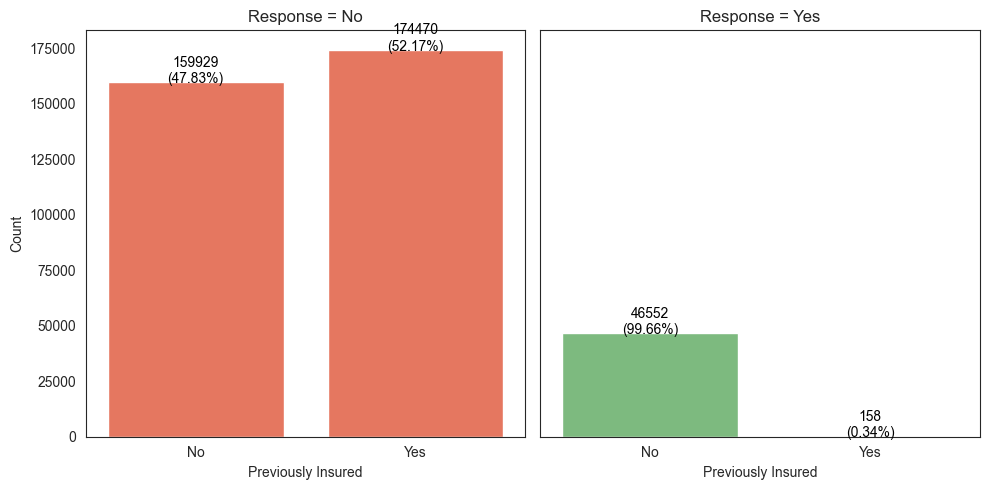

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)

# Loop over the Response categories and plot the data for each Response category
for i, response in enumerate(resp_previnsured['Response'].unique()):
    data = resp_previnsured[resp_previnsured['Response'] == response]
    total_count = data['count'].sum()
    
    sns.barplot(x='Previously_Insured', y='count', data=data, hue='Response', 
                palette='Reds' if response == 'No' else 'Greens', ax=axs[i], legend=False)
    
    # Annotate each bar with count and percentage
    for p in axs[i].patches:
        count = p.get_height()  # Get the height of the bar (count value)
        percentage = count / total_count * 100  # Calculate percentage
        # Annotate with count and percentage
        axs[i].annotate(f'{int(count)}\n({percentage:.2f}%)', 
                        (p.get_x() + p.get_width() / 2., p.get_height()),  # Coordinates for the text
                        ha='center', va='center', fontsize=10, color='black', 
                        xytext=(0, 8), textcoords='offset points')  # Offset the text slightly above the bar

    
    axs[i].set_title(f'Response = {response}')
    axs[i].set_xlabel('Previously Insured')

axs[0].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [30]:
resp_previnsured[(resp_previnsured["Previously_Insured"] == 'No') & \
                 (resp_previnsured["Response"] == 1)]["count"] \
                / (resp_previnsured[resp_previnsured["Previously_Insured"] == 'No']["count"].sum()) * 100

Series([], Name: count, dtype: float64)

From the bar chart above we can conclude that out of the customers who do not have Vehicle Insurance, **99.66% of them would buy the Vehicle Insurance** offered by the Health Insurance Company. However, when we consider the full sample, **the company is attracting only 22.54% of customers who do not have Auto Insurance.** 
<br><br>

In terms of customers switching from their Vehicle Insurance to the Health Insurance company's Vehicle Insurance, only a tiny portion of customers would switch from their Vehicle Insurance. **Health Insurance company's Vehicle Insurance may not be more attractive and with more benefits compared to others.**

#### Vehicle Age vs Response

It's pretty clear to think that if a person has a brand new car, automatically thinks of acquiring a Vehicle Insurance, to be more safe and relaxed in case of something happens. <br><br>
Let's see if we see that pattern here.

In [31]:
vehicle_age_resp = df_train.groupby(["Vehicle_Age", "Response"])["id"] \
                                    .count() \
                                        .to_frame() \
                                            .rename(columns={'id':'count'}) \
                                                .reset_index()

vehicle_age_resp["Response"] = vehicle_age_resp["Response"].replace({0:'No', 1:'Yes'})
# Order Vehicle_Age indexes to have the correct order in the plot
vehicle_age_resp = vehicle_age_resp.reindex([2,3,0,1,4,5])
vehicle_age_resp

,Vehicle_Age,Response,count
2,< 1 Year,No,126063
3,< 1 Year,Yes,5789
0,1-2 Year,No,132376
1,1-2 Year,Yes,27819
4,> 2 Years,No,9080
5,> 2 Years,Yes,3760


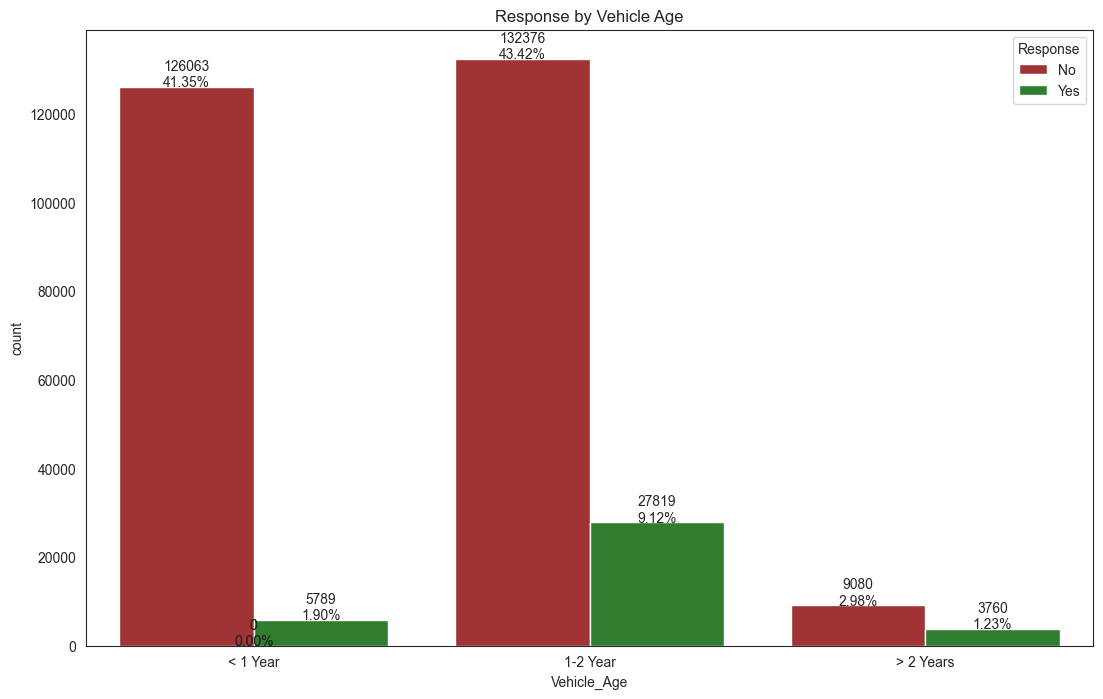

In [32]:
plt.figure(figsize=(13,8))
ax = sns.barplot(x='Vehicle_Age', y='count', hue='Response', data=vehicle_age_resp, 
                 palette=['firebrick','forestgreen']) # ["indianred","firebrick"] ["mediumseagreen", "forestgreen"]

# Calculate count and percentage for each bar
total_counts = vehicle_age_resp['count'].sum()
for p in ax.patches:
    height = p.get_height() # Get the height of the bar (count value)
    count = int(height)
    percentage = (count / total_counts) * 100
    ax.annotate(f'{count}\n{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height), # Coordinates for the text
                ha='center', va='center', xytext=(0, 9), textcoords='offset points') # Offset the text slightly above the bar

plt.title("Response by Vehicle Age")
plt.show()

### **Numerical Variables**

#### Age vs Response

It is also important to understand if the `Age` can be a factor when it comes to acquire a Vehicle Insurance.

In [33]:
age_resp = df_train.groupby(['Age', 
                            'Response'])['id'].count().to_frame() \
                                .rename(columns={'id': 'count'}) \
                                    .reset_index()
age_resp


,Age,Response,count
0,20,0,4817
1,20,1,134
2,21,0,12731
3,21,1,460
4,22,0,16143
...,...,...,...
125,82,1,1
126,83,0,14
127,83,1,1
128,84,0,10


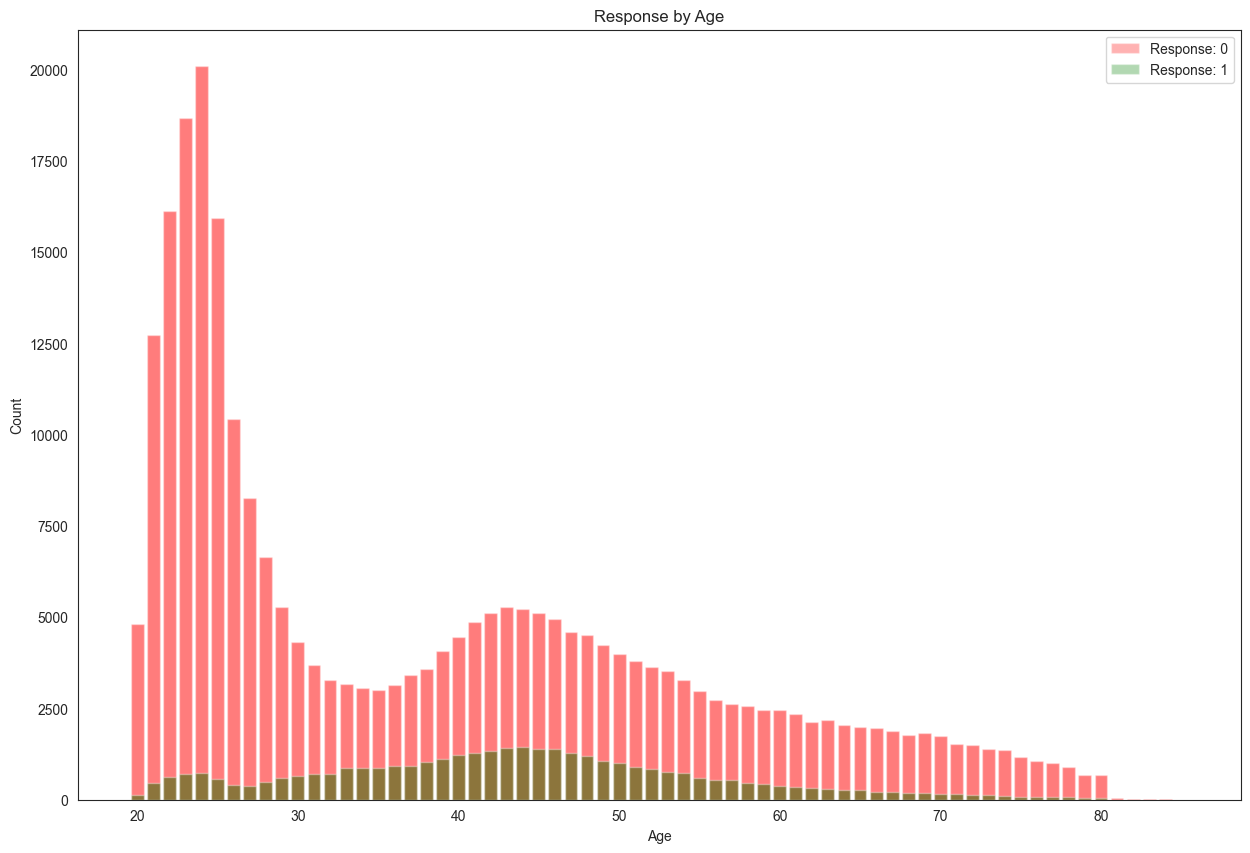

In [34]:
plt.figure(figsize=(15,10))
plt.bar(age_resp['Age'], age_resp['count'], color=['red', 'green'], alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Response by Age')
bars = plt.bar(age_resp['Age'], age_resp['count'], color=['red', 'green'], alpha=0.3)

plt.legend(bars, ['Response: 0', 'Response: 1'])
plt.show()

In terms of total of observations, it's clear that the 'No' `Response` is predominant. 
<br><br>
Let's explore this relationship but with another statistic like **probability**. **Probability** focuses on relative frequencies instead of raw counts.

In [35]:
response_age = df_train[['Age', 'Response']]
response_1 = response_age[response_age['Response'] == 1]
response_0 = response_age[response_age['Response'] == 0]

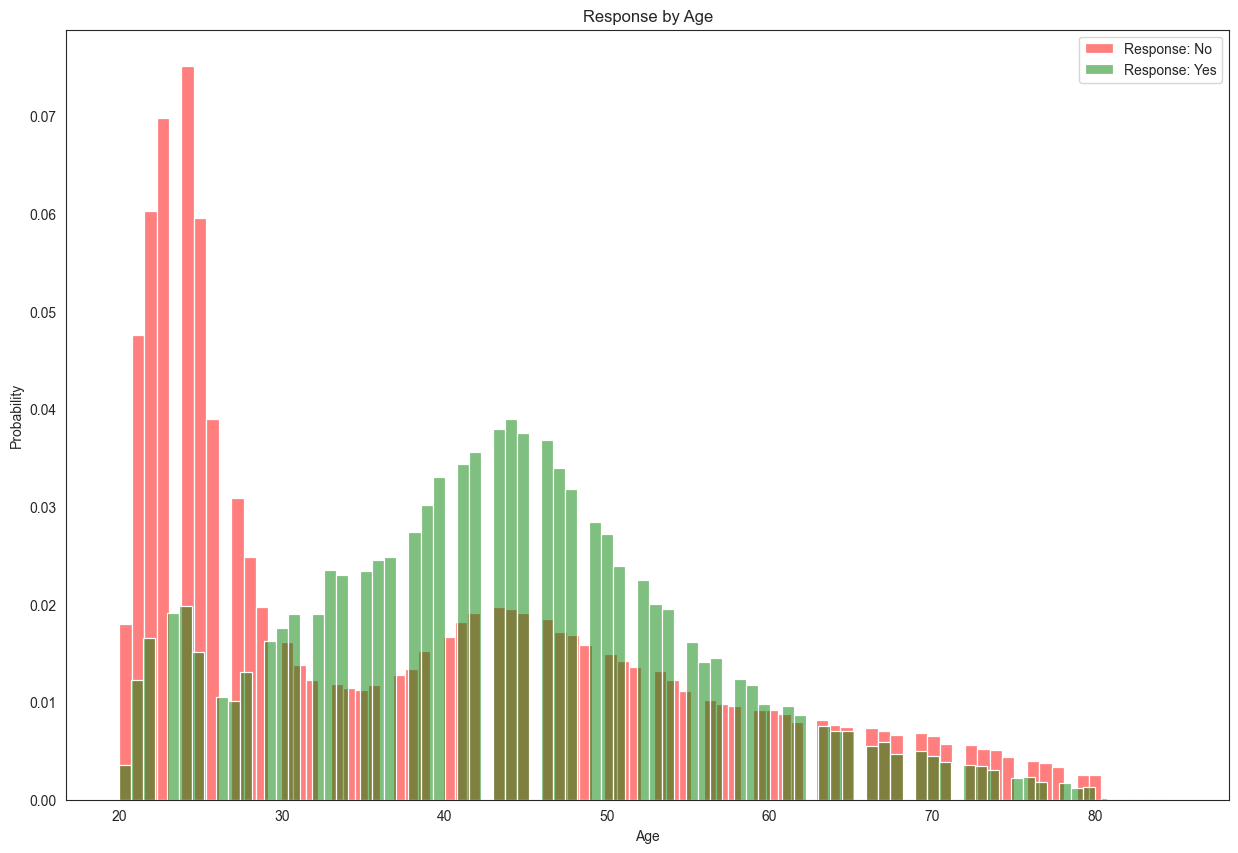

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))
# Plot the histogram for Response 0
sns.histplot(response_0['Age'], ax=ax, stat='probability', color='red', # color='#EFB792', 
             alpha=0.5, element='bars', fill=True, 
             bins=int(response_age['Age'].max()))
# Plot the histogram for Response 1
sns.histplot(response_1['Age'], ax=ax, stat='probability', color='green', # color='#8DE5A1', 
             alpha=0.5, element='bars', fill=True, 
             bins=int(response_age['Age'].max()))

ax.set_xlabel('Age')
ax.set_ylabel('Probability')
ax.set_title('Response by Age')
ax.legend(labels=['Response: No', 'Response: Yes'])
plt.show()

When explored the **probability** of the `Response` of the clients by their `Age`, it's possible to observe that there's a higher probability that clients within 31-58 years of Age, are interested in acquiring a Vehicle Insurance. <br>
This might occur due to their finantial stability, which oposes to the clients below 30 years old, and the fact that above 60 years old, people start to drive less (because of visual problems, health concerns, etc).

#### Vintage vs Response

We can now explore whether a Health Insurance customer's seniority may have an impact on acquiring a Vehicle Insurance provided by this company. 

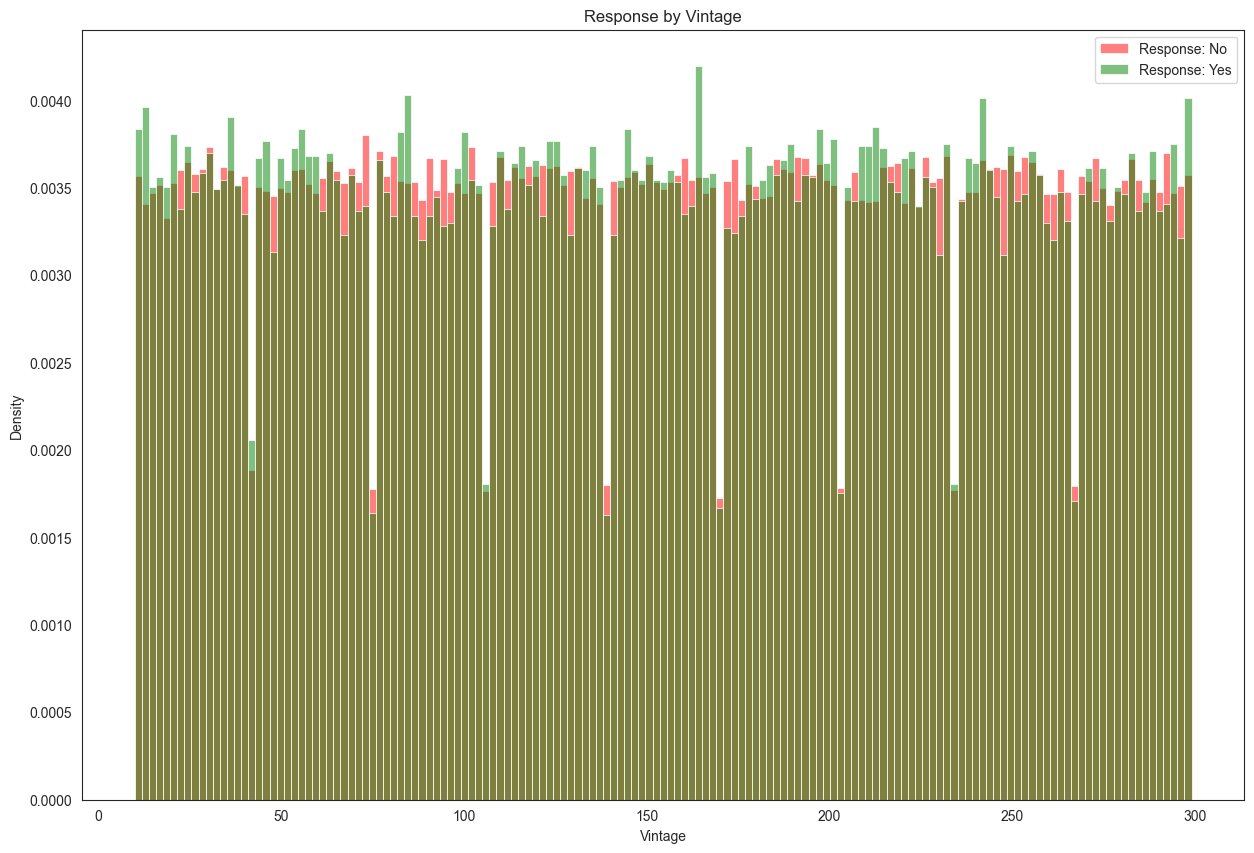

In [37]:
vintage_resp = df_train[["Vintage", "Response"]]

fig, ax = plt.subplots(figsize=(15, 10))
# Plot the histogram for Response 0
sns.histplot(vintage_resp[vintage_resp["Response"]==0]["Vintage"], ax=ax, stat='density',
             color='red', alpha=0.5, element='bars', fill=True, 
             bins=int(vintage_resp['Vintage'].max()/ 2)) # ,int(vintage_resp['Vintage'].max()/ 2)
# Plot the histogram for Response 1
sns.histplot(vintage_resp[vintage_resp["Response"]==1]["Vintage"], ax=ax, stat='density',
             color='green', alpha=0.5, element='bars', fill=True, 
             bins=int(vintage_resp['Vintage'].max()/ 2))

ax.set_xlabel('Vintage')
ax.set_ylabel('Density')
# ax.set_ylim(0.0025)
ax.set_title('Response by Vintage')
ax.legend(labels=['Response: No', 'Response: Yes'])
plt.show()

From the histogram above, it is possible to observe that there are **no clear differences** between the density in different seniority categories of the Health Insurance clients who are more inclined to acquire a Vehicle Insurance and those who aren't, regardless the slight dominance in "No" Responses.

In [38]:
## Could be interest to associate this with the Previously_Insured variable

#### Region vs Response

In [39]:
region_code_resp = df_train[["Region_Code", "Response"]]
region_code_resp_0 = region_code_resp[region_code_resp["Response"] == 0]
region_code_resp_1 = region_code_resp[region_code_resp["Response"] == 1]

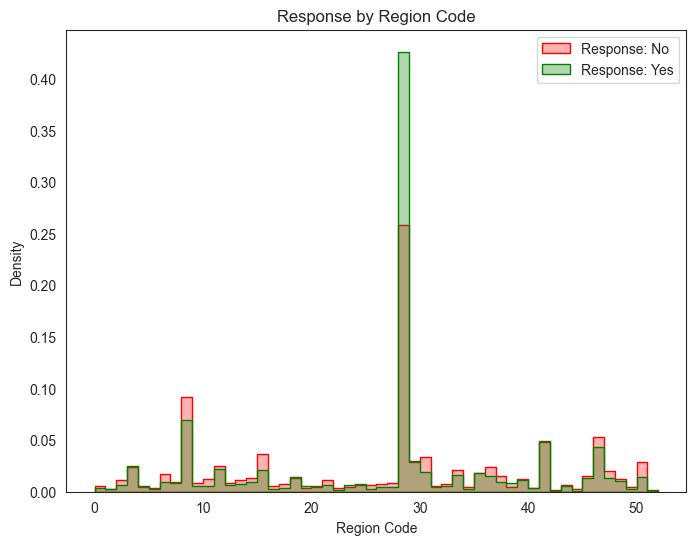

In [40]:
fig, ax = plt.subplots(figsize=(8,6))
# Plot the density histogram for Response 0
sns.histplot(region_code_resp_0["Region_Code"], ax=ax, 
             stat='density', color='red', alpha=0.3, element='step', fill=True, 
             bins=int(region_code_resp['Region_Code'].max()))
# Plot the density histogram for Response 1
sns.histplot(region_code_resp_1["Region_Code"], ax=ax, 
             stat='density', color='green', alpha=0.3, element='step', fill=True, 
             bins=int(region_code_resp['Region_Code'].max()))

ax.set_xlabel("Region Code")
ax.set_ylabel("Density")
ax.set_title("Response by Region Code")
ax.legend(labels=["Response: No", "Response: Yes"])
plt.show()


In [41]:
int(region_code_resp["Region_Code"].value_counts().idxmax())

28

There is a clear **spike in Region Code 28, where the majority of the Responses is "Yes"**. This may represent a region where customers are much more likely to buy vehicle insurance.
<br><br>

The other Region Codes have a spread of "Yes" and "No" Responses and in significantly low densities. Overall, there are more "No" Responses than "Yes" Responses (due to the fact that most of our Responses are "No")
<br><br>

Regarding the spike in Region Code 28, this might occur because of this being **an area traditionally with more accidents than the others**, increasing the need for a Vehicle Insurance. Let's explore this below:

In [42]:
damage_regcode_resp = df_train.groupby(["Region_Code",
                                        "Response"])["Vehicle_Damage"] \
                                        .count().to_frame("count").reset_index()

damage_regcode_resp["Response"] = damage_regcode_resp["Response"].replace({0:"No", 1:"Yes"})
damage_regcode_resp

,Region_Code,Response,count
0,0.0,No,1482
1,0.0,Yes,141
2,1.0,No,711
3,1.0,Yes,85
4,2.0,No,2983
...,...,...,...
101,50.0,Yes,518
102,51.0,No,122
103,51.0,Yes,24
104,52.0,No,190


The plot below should be passed to density instead of raw counts

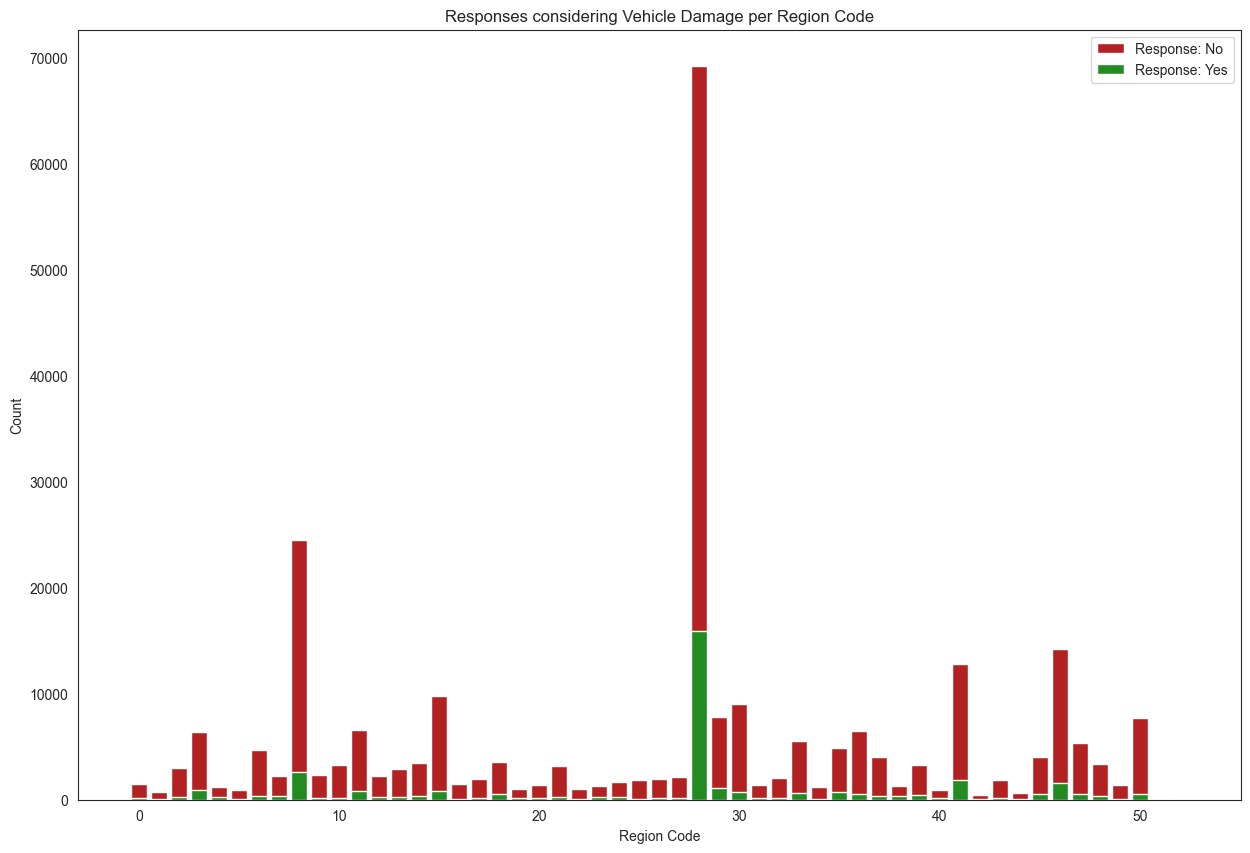

In [43]:
plt.figure(figsize=(15,10))
plt.xlabel('Region Code')
plt.ylabel('Count')
plt.title('Responses considering Vehicle Damage per Region Code')
stacked_bars = plt.bar(damage_regcode_resp['Region_Code'], damage_regcode_resp['count'],
                       color=['firebrick', 'forestgreen']) # , alpha=0.6
plt.legend(stacked_bars, ['Response: No', 'Response: Yes'])
plt.show()

In [44]:
damage_regcode_resp_yes = df_train[df_train["Response"]==1] \
                                        .groupby(["Vehicle_Damage", 
                                                  "Region_Code"])["Response"] \
                                                    .count() \
                                                        .to_frame() \
                                                            .reset_index() \
                                                            .rename(columns={'Response': 'count'})

damage_regcode_resp_yes

,Vehicle_Damage,Region_Code,count
0,No,2.0,3
1,No,3.0,28
2,No,4.0,7
3,No,5.0,4
4,No,6.0,17
...,...,...,...
97,Yes,48.0,383
98,Yes,49.0,109
99,Yes,50.0,510
100,Yes,51.0,24


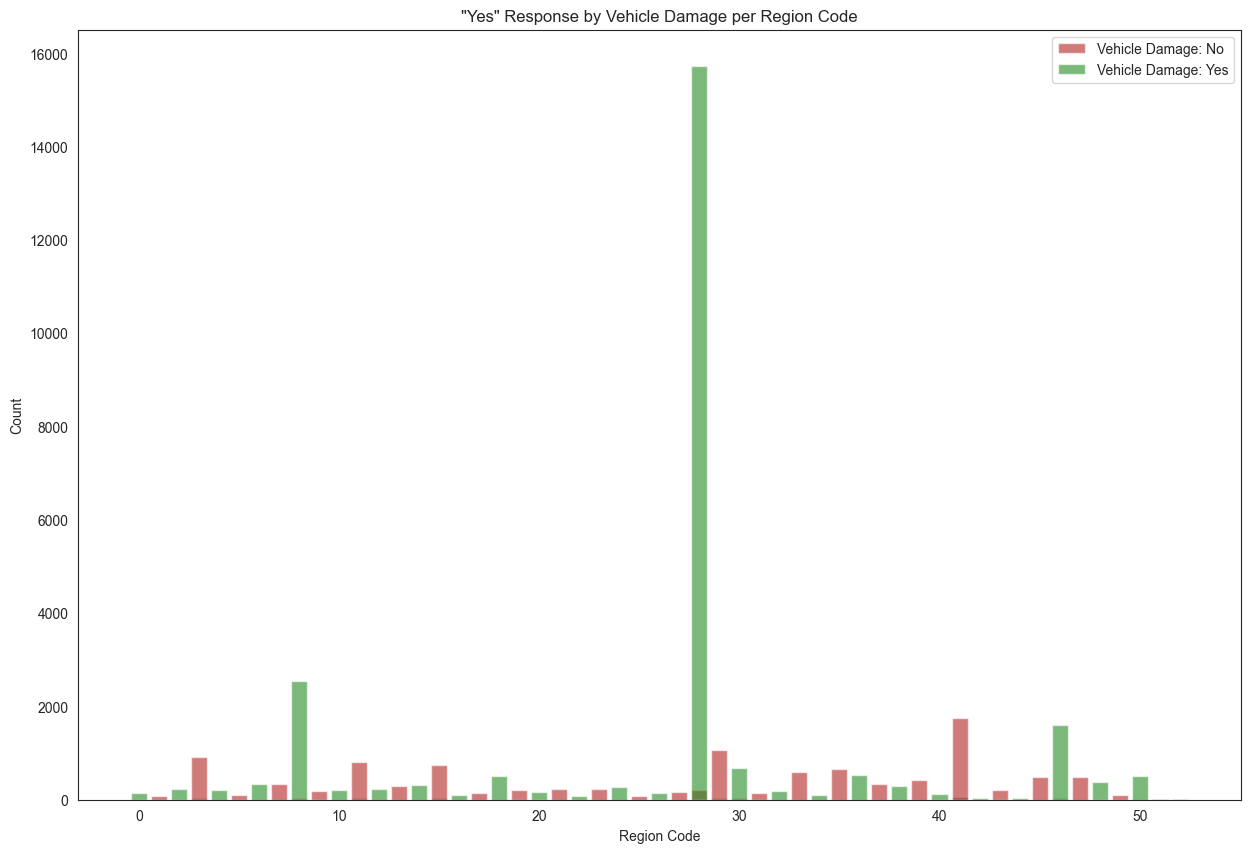

In [45]:
plt.figure(figsize=(15,10))
plt.xlabel('Region Code')
plt.ylabel('Count')
plt.title('"Yes" Response by Vehicle Damage per Region Code')
stacked_bars = plt.bar(damage_regcode_resp_yes['Region_Code'], damage_regcode_resp_yes['count'],
                       color=['firebrick', 'forestgreen'], alpha=0.6) # 
plt.legend(stacked_bars, ['Vehicle Damage: No', 'Vehicle Damage: Yes'])
plt.show()

#### Policy Sales Channel vs Response

The Health Insurance company has several communication channels to sell their insurance. Let's take a look at whether the channel through which Health Insurance was acquired can have an effect on the acquisiton of a Vehicle Insurance. 

In [46]:
channel_resp = df_train[["Policy_Sales_Channel", "Response"]]
channel_resp_0 = channel_resp[channel_resp["Response"] == 0]
channel_resp_1 = channel_resp[channel_resp["Response"] == 1]

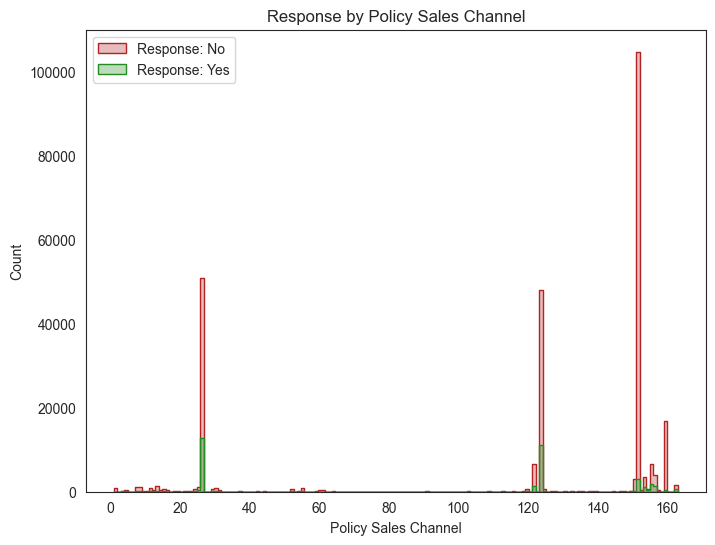

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the density histogram for Response 0
sns.histplot(channel_resp_0['Policy_Sales_Channel'], ax=ax, stat='count', color='firebrick', 
             alpha=0.3, element='step', fill=True,
             bins=int(channel_resp_0['Policy_Sales_Channel'].max()))
# Plot the density histogram for Response 1
sns.histplot(channel_resp_1['Policy_Sales_Channel'], ax=ax, stat='count', color='forestgreen', 
             alpha=0.3, element='step', fill=True,
             bins=int(channel_resp_1['Policy_Sales_Channel'].max()))

ax.set_xlabel('Policy Sales Channel')
ax.set_ylabel('Count')
ax.set_title('Response by Policy Sales Channel')
ax.legend(labels=['Response: No', 'Response: Yes'], loc='upper left')
plt.show()

In [48]:
channel_resp["Policy_Sales_Channel"].value_counts().head(15)

Policy_Sales_Channel
152.0    107998
26.0      63709
124.0     59187
160.0     17348
156.0      8472
122.0      7951
157.0      5386
154.0      4772
151.0      3082
163.0      2328
13.0       1505
25.0       1489
7.0        1270
8.0        1195
30.0       1122
Name: count, dtype: int64

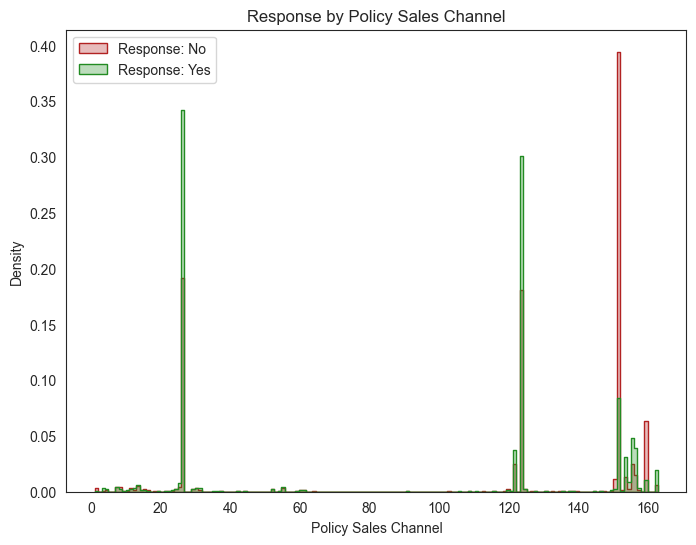

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the density histogram for Response 0
sns.histplot(channel_resp_0['Policy_Sales_Channel'], ax=ax, stat='density', color='firebrick', 
             alpha=0.3, element='step', fill=True,
             bins=int(channel_resp_0['Policy_Sales_Channel'].max()))
# Plot the density histogram for Response 1
sns.histplot(channel_resp_1['Policy_Sales_Channel'], ax=ax, stat='density', color='forestgreen', 
             alpha=0.3, element='step', fill=True,
             bins=int(channel_resp_1['Policy_Sales_Channel'].max()))

ax.set_xlabel('Policy Sales Channel')
ax.set_ylabel('Density')
ax.set_title('Response by Policy Sales Channel')
ax.legend(labels=['Response: No', 'Response: Yes'], loc='upper left')
plt.show()

Clearly there are 4 channels that are more used to contact these clients: 152, 26, 124 and 160. Unfortunely, we don't have access to what these channels mean, which makes our interpretation of this variable difficult.

#### Annual Premium vs Response

As seen in Data Understanding chapter, in Numerical Features Analysis, the `Annual_Premium` variable has several **outliers**, causing this variable to be very skewed. 
<br><br>

These outliers can be negative to the performance of our models, so we need to inspect these values.

To calculate the outliers we can use the **Interquartile Method**, which bases on:

1. Sort your data from low to high
2. Identify the first quartile (Q1) and the third quartile (Q3).
3. Calculate your IQR = Q3 – Q1
4. Calculate your upper fence (data point with the biggest value in the data set that isn’t an outlier) = Q3 + (1.5 * IQR)
5. Calculate your lower fence (data point with the lowest value in the data set that isn’t an outlier) = Q1 – (1.5 * IQR)
6. Use the fences to highlight any outliers, all values that fall outside your fences.

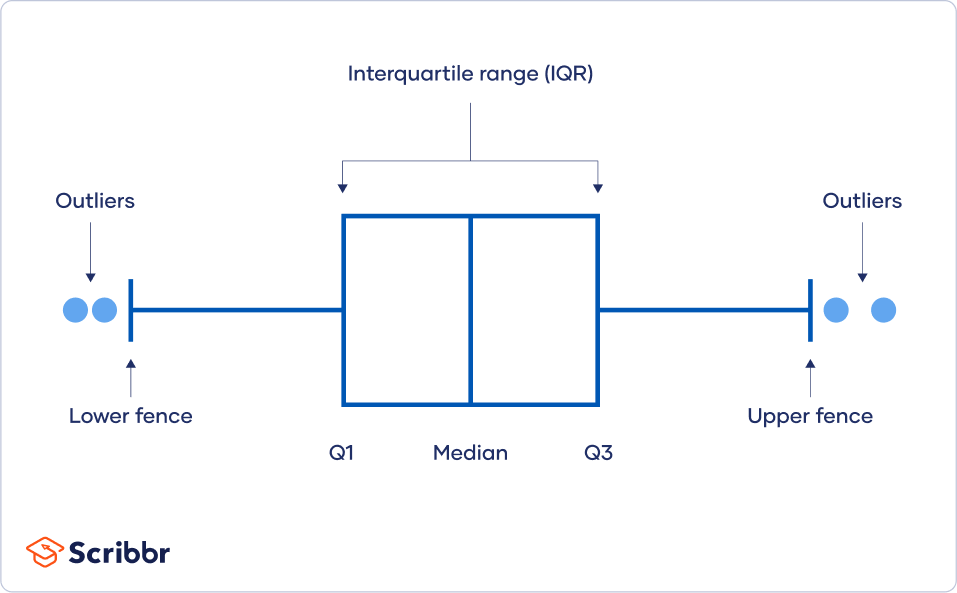

In [50]:
Q1 = df_train['Annual_Premium'].quantile(0.25)
Q3 = df_train['Annual_Premium'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1
print(f"Interquartile Range (IQR): {IQR}")

# Upper and lower fences
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
print(f"\nThe Annual Premium lower fence is {lower_fence} and"
       " the Annual Premium upper fence is {upper_fence}")


Interquartile Range (IQR): 15040.0

The Annual Premium lower fence is 1843.0 and the Annual Premium upper fence is {upper_fence}


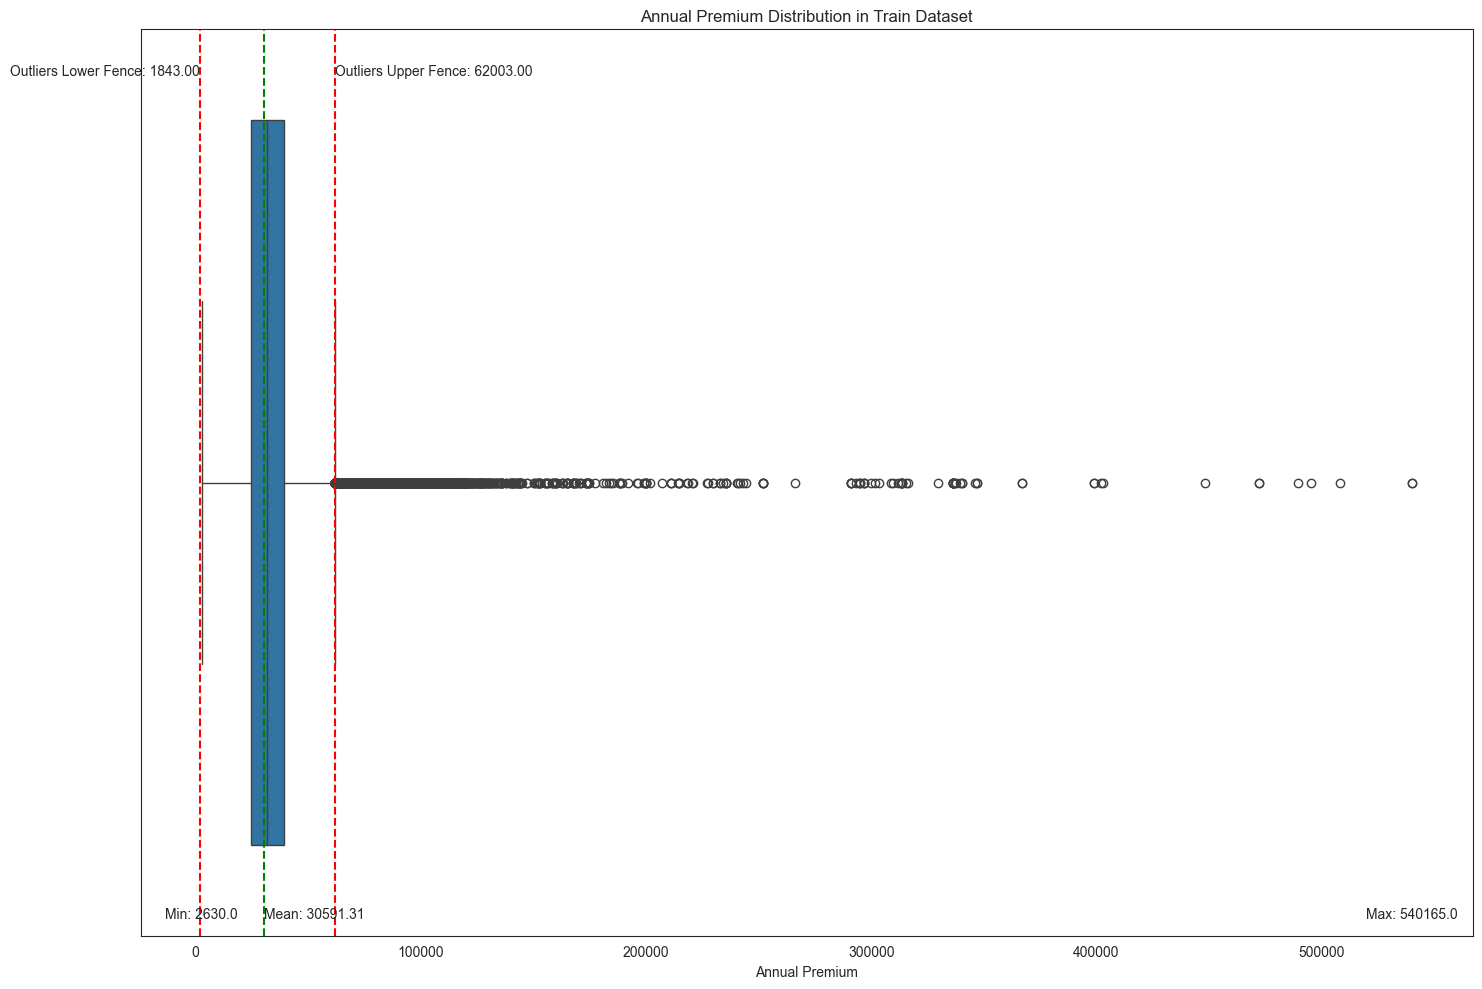

In [51]:
plt.figure(figsize=(15,10))
sns.boxplot(df_train['Annual_Premium'],orient='h')

# add the summary statistics to the plot
plt.text(df_train['Annual_Premium'].mean(), 0.48, 
         f"Mean: {df_train['Annual_Premium'].mean():.2f}", ha='left')
plt.axvline(x=df_train['Annual_Premium'].mean(), color='g', linestyle='--')
plt.axvline(x=upper_fence, color='r', linestyle='--')
plt.text(upper_fence, -0.45, f"Outliers Upper Fence: {upper_fence:.2f}", ha='left')
plt.axvline(x=lower_fence, color='r', linestyle='--')
plt.text(lower_fence, -0.45, f"Outliers Lower Fence: {lower_fence:.2f}", ha='right')
# plt.text(df_train['Annual_Premium'].median(), -0.42, 
#          f"Median: {df_train['Annual_Premium'].median():.2f}", ha='left')
plt.text(df_train['Annual_Premium'].max(), 0.48, 
         f"Max: {df_train['Annual_Premium'].max()}", ha='center')
plt.text(df_train['Annual_Premium'].min(), 0.48, 
         f"Min: {df_train['Annual_Premium'].min()}", ha='center')

plt.title('Annual Premium Distribution in Train Dataset')
plt.xlabel('Annual Premium')
plt.tight_layout()
plt.show()

From the Box Plot above with the upper and lower fences depicted as red lines, it's possible to observe that there are **no Annual Premiums below our lower fence**, but there are **several client's Annual Premiums above the upper fence**. Let's calculate how many client's have Annual Premiums above the upper fence:   

In [52]:
clients_outliers = len(df_train[df_train['Annual_Premium'] > upper_fence])
clients_outliers_perc = round((clients_outliers / len(df_train['Annual_Premium'])) * 100, 1)
print(f"There are {clients_outliers} clients ({clients_outliers_perc}% of the train dataset)"
      " with Annual Premiums considered outliers.")

There are 8280 clients (2.7% of the train dataset) with Annual Premiums considered outliers.


The number of clients with Annual Premiums considered outliers in the dataset is relatively low (2.7%), we might **drop these clients from our dataset**.

<Axes: xlabel='Annual_Premium', ylabel='Count'>

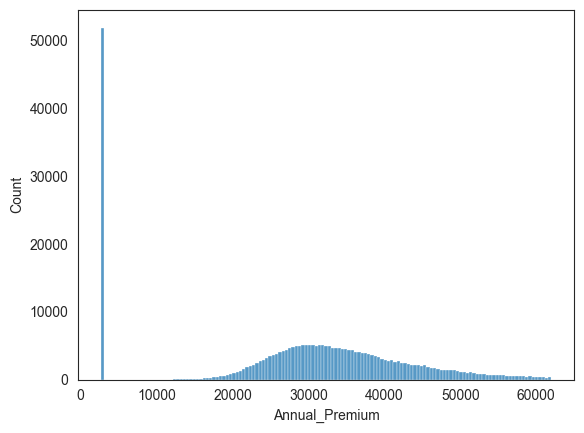

In [53]:
annual_premium_no_outliers = df_train[df_train['Annual_Premium'] <= upper_fence]
sns.histplot(annual_premium_no_outliers["Annual_Premium"])

In [54]:
annual_premium_no_outliers_0 = annual_premium_no_outliers[annual_premium_no_outliers["Response"] == 0]
annual_premium_no_outliers_1 = annual_premium_no_outliers[annual_premium_no_outliers["Response"] == 1]

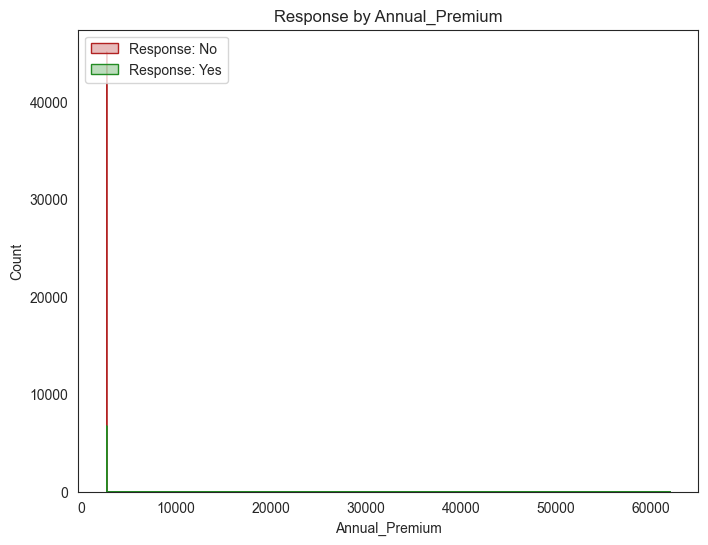

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the density histogram for Response 0
sns.histplot(annual_premium_no_outliers_0['Annual_Premium'], ax=ax, stat='count', 
             color='firebrick', alpha=0.3, element='step', fill=True,
             bins=int(annual_premium_no_outliers_0['Annual_Premium'].max()))
# Plot the density histogram for Response 1
sns.histplot(annual_premium_no_outliers_1['Annual_Premium'], ax=ax, stat='count', 
             color='forestgreen', alpha=0.3, element='step', fill=True,
             bins=int(annual_premium_no_outliers_1['Annual_Premium'].max()))

ax.set_xlabel('Annual_Premium')
ax.set_ylabel('Count')
ax.set_title('Response by Annual_Premium')
ax.legend(labels=['Response: No', 'Response: Yes'], loc='upper left')
plt.show()

## **Feature Creation**

There are some **new features that can be created** to provide **more information and predictive power** to out ML model.

**Interaction Features:**

Age × Driving Experience: Create an interaction feature to see if older, more experienced drivers are less likely to buy insurance. <br>
Annual Premium × Vehicle Age: Combine these two to see if people with older vehicles but higher premiums behave differently.

**Bin Continuous Variables:**

Binning Age: Group ages into categories like young (18-30), middle-aged (31-50), and senior (51+).
Binning Annual Premium: Convert this into categories such as low, medium, and high premiums.

**Ratios/Proportions:**

Annual Premium / Age: This might capture how much insurance premium people are paying relative to their age.
Vehicle Age / Policy Age: A ratio showing how old the vehicle is compared to the policyholder’s age.

**Vehicle Ownership Patterns:**

Vehicle Damage and Age: Create a feature that captures whether a person with an older vehicle has reported past damage. This could indicate riskier behavior.

**Policy Tenure Features:**

Driving Experience / Age: This feature could reflect a ratio indicating what portion of their life someone has been driving, indicating experience and potentially risk appetite.

**Interaction with Response Variable:**

Feature Target Encoding: For categorical variables like Gender, Vehicle_Damage, etc., create a target-encoded version that captures the likelihood of buying vehicle insurance based on past data.

**Binary Features for Conditions:**

Premium Above Mean: Create a binary feature that checks if the premium is above the average.
High-Risk Profile: A combination of features like Vehicle Damage, Vehicle Age, and Annual Premium could indicate high-risk profiles for certain customers.

In [155]:
# to see if people with older vehicles but higher premiums behave differently
# df_train["Vehicle_Premium"] = df_train["Vehicle_Age"] * df_train["Annual_Premium"]

In [156]:
# # to capture how much insurance premium people are paying relative to their age
# df_train["Premium_by_Age"] = df_train["Annual_Premium"] / df_train["Age"]

In [157]:
# # to showing how old the vehicle is compared to the policyholder’s age
# df_train["Vehicle_Policyholder_Age"] = df_train["Vehicle_Age"] / df_train["Age"]

In [176]:
# # indicate high-risk profiles for certain clients
# df_train["Risk_Profile"] = ((df_train['Vehicle_Damage'] == 1) & 
#                             (df_train['Annual_Premium'] > df_train['Annual_Premium'].median()) & 
#                             (df_train['Vehicle_Age'] > '> 2 Years')).astype(np.int64)

In [177]:
# # to checks if the premium is above the median
# df_train['Premium_Above_Median'] = (df_train['Annual_Premium'] > 
#                                     df_train['Annual_Premium'].median()).astype(np.int64)

In [ ]:
# # Group clients ages into categories
# bins = [18, 25, 40, 60, 100] # max 'Age' is 85 yo
# labels = ['Young_Adult', 'Adult', 'Middle-aged', 'Senior']
# df_train['Age_Binned'] = pd.cut(df_train['Age'], bins=bins, labels=labels)

In [ ]:
# # Group clients 'Annual_Premiums' into categories
# bins = [0, 10000, 30000, 60000] # Medium will be around 30.000 since median = 31.697
# labels = ['Low', 'Medium', 'High']
# df_train['Premium_Binned'] = pd.cut(df_train['Annual_Premium'], bins=bins, labels=labels)

## **Data UnderSampling**

1. **Cluster Centroids Undersampling:**

**How it works:** This technique applies clustering (typically K-means) to the majority class, reducing 
the dataset by replacing clusters with their centroids. This helps keep the most representative points of the majority class.

**Why it’s good:** It can preserve the most representative samples of the majority class, especially if the data points are naturally grouped into clusters.


2. **NearMiss:**

**How it works:** NearMiss is a family of undersampling techniques that selects majority class samples 
that are closest to the minority class. There are three variations of NearMiss:

 - `NearMiss-1:` Selects majority class points whose average distance to the nearest minority class points is smallest.
 - `NearMiss-2:` Selects majority class points that are farthest from other majority class points, but closest to the minority class.
 - `NearMiss-3:` Keeps a fixed number of majority class points closest to each minority class point.

**Why it’s good:** NearMiss ensures that the samples in the majority class that are most similar or closest to the minority class are retained, which can improve the decision boundary.


3. **Tomek Links:**

**How it works:** A Tomek Link is a pair of points from different classes that are the closest neighbors to each other. If such a pair exists, the point from the majority class is removed. This technique helps clean up overlapping classes.

**Why it’s good:** By removing points from the majority class that are closest to minority class points, Tomek Links refine the class boundary, reducing potential confusion for the model.


4. **Edited Nearest Neighbors (ENN):**

**How it works:** ENN removes majority class samples whose class label differs from the majority class of its nearest neighbors (usually k=3 nearest neighbors).

**Why it’s good:** This method reduces noisy majority samples, improving the model's ability to learn a clear class boundary between the majority and minority classes.


5. **Condensed Nearest Neighbors (CNN):**

**How it works:** CNN works by selecting a subset of the majority class samples that are critical to define the decision boundary (border points). It discards non-essential points far from the decision boundary.

**Why it’s good:** CNN maintains only the most relevant and boundary-defining majority samples, making the dataset smaller but still informative.


6. **Instance Hardness Threshold (IHT):**

**How it works:** IHT trains a classifier and ranks majority class instances based on how difficult they are to classify. The hardest-to-classify majority instances are kept, and the easiest ones (likely not adding value to the model) are removed.


**Why it’s good:** This technique ensures that majority class samples contributing most to the classification challenge are retained, which can improve model performance.



7. **Random Undersampling with Replacement:**

**How it works:** It randomly selects samples from the majority class, but with an added step of ensuring replacement if necessary. This can help maintain key samples that might otherwise be discarded with traditional random undersampling.

**Why it’s good:** While random undersampling risks losing important information, incorporating replacement strategies can help preserve key samples.

In [7]:
# Instantiate Feature Engineering object
feature_engineering = FeatureEngineering(df_train)

In [8]:
feature_engineering.ordinal_encoding("Vehicle_Age", ['< 1 Year', 
                                                     '1-2 Year', 
                                                     '> 2 Years'])
feature_engineering.categorical_encoding("Gender", {'Female': int(0), 
                                                    'Male':int(1)})
feature_engineering.categorical_encoding("Vehicle_Damage", {'No':int(0), 
                                                            'Yes':int(1)})

df_train_encoded = feature_engineering.df

In [9]:
# Instantiate Data Undersampling object 
data_undersampling = Undersampling(df_train_encoded, "Response")

In [10]:
data_undersampling.near_miss_undersampling(1)
df_train_und = data_undersampling.near_miss_df_train_modified
df_train_und

Class distribution before undersampling: Response
0           267519
1            37368
Name: count, dtype: int64

Class distribution before undersampling: Response
0           37368
1           37368
Name: count, dtype: int64


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,164035,0,50,1,29.0,1,1,0,2630.0,26.0,179,0
1,377218,0,34,1,28.0,1,1,0,2630.0,160.0,166,0
2,43545,1,26,1,20.0,0,0,1,2630.0,156.0,94,0
3,43573,1,30,1,7.0,0,0,1,2630.0,160.0,65,0
4,185026,1,40,1,28.0,1,1,0,2630.0,154.0,203,0
...,...,...,...,...,...,...,...,...,...,...,...,...
74731,157720,1,53,1,8.0,0,2,1,2630.0,7.0,198,1
74732,182229,1,67,1,46.0,0,1,1,31564.0,124.0,127,1
74733,75837,1,30,1,15.0,0,1,1,39443.0,154.0,182,1
74734,47376,1,49,1,41.0,0,1,1,39444.0,12.0,17,1


## **Data Augmentation**

There are several techniques we can use to upsample the minority class of our target variable in an unbalanced dataset.

>**1. Random oversampling**: This technique involves randomly duplicating examples from the minority class until it has the same number of samples as the majority class. 

>**2. Synthetic Minority Over-sampling Technique (SMOTE)**: SMOTE generates new synthetic samples in the minority class by interpolating between existing samples. This is done by selecting one sample from the minority class and finding its k nearest neighbors. Then, synthetic examples are created by interpolating between this sample and its k nearest neighbors. 

  > **Borderline-SMOTE**: There are examples that are misclassified are likely ambiguous and in a region of the edge or border of decision boundary where class membership may overlap. This modified to SMOTE is called Borderline-SMOTE, where occurs the oversampling of just the borderline cases in minority class.

  > **Borderline-SMOTE SVM**: This modified SMOTE is similar to the previous Borderline-SMOTE, differing by synthetizing more examples of the minory class away from the region of class overlap.

>**3. Adaptive Synthetic (ADASYN)**: ADASYN generates synthetic samples based on the density of examples in the feature space. It creates more synthetic samples in regions with lower density of minority samples and fewer synthetic samples in regions with higher density of minority samples. 

>**4. Undersampling**: Undersampling involves randomly selecting examples from the majority class until it has the same number of samples as the minority class. However, this technique can lead to a loss of information from the majority class.

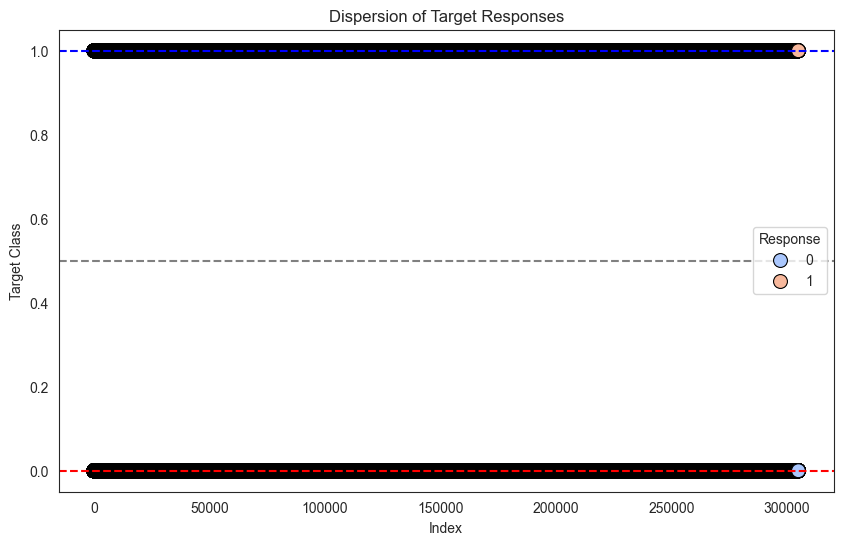

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y is your target variable (binary: 0 and 1)
y = df_train['Response']  # Get the target responses

# Create a DataFrame for plotting if needed
plot_df = df_train.reset_index()  # Reset index for plotting
plot_df['index'] = plot_df.index  # Add index column for x-axis

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='index', y='Response', data=plot_df, hue='Response', 
                palette='coolwarm', s=100, edgecolor='k')

# Add horizontal lines for clarity
plt.axhline(y=0.5, color='gray', linestyle='--')  # Line at 0.5 to distinguish classes
plt.axhline(y=0, color='red', linestyle='--')     # Line at 0 for class 0
plt.axhline(y=1, color='blue', linestyle='--')    # Line at 1 for class 1

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Target Class')
plt.title('Dispersion of Target Responses')

# Show the plot
plt.show()


First of all, let's **drop the `id` column from our dataset**, since it's not used for any of the next steps:

In [57]:
df_train = df_train.drop(columns=["id"]).reset_index(drop=True)

To use `SMOTE` or `ADASYN` Data Augmentation techniques,  **categorical variables need to be enconded!**

In [58]:
# Instantiate Feature Engineering object
feature_engineering = FeatureEngineering(df_train)

In [59]:
feature_engineering.ordinal_encoding("Vehicle_Age", ['< 1 Year', 
                                                     '1-2 Year', 
                                                     '> 2 Years'])
feature_engineering.categorical_encoding("Gender", {'Female': int(0), 
                                                    'Male':int(1)})
feature_engineering.categorical_encoding("Vehicle_Damage", {'No':int(0), 
                                                            'Yes':int(1)})

df_train_categorical_encoded = feature_engineering.df

Once the categorical variables are encoded, let's proceed to Data Augmentation.

In [60]:
# Instantiate Data Augmentation object 
data_augmentation = Augmentation(df_train_categorical_encoded, "Response")

In [81]:
data_augmentation.svm_smote_augmentation()
df_train_aug = data_augmentation.svm_smote_df_train_modified
df_train_aug

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,22,1,40.000000,0,0,1,25455.000000,152.000000,203,0
1,0,26,1,8.000000,1,0,0,38393.000000,26.000000,45,0
2,0,32,1,28.000000,0,0,1,32118.000000,122.000000,35,1
3,1,32,1,37.000000,0,0,1,37711.000000,152.000000,215,0
4,0,24,1,28.000000,0,0,1,48706.000000,156.000000,222,0
...,...,...,...,...,...,...,...,...,...,...,...
535033,1,39,1,36.390188,0,1,1,2630.000000,156.609812,204,1
535034,1,35,1,42.911774,0,0,1,43639.411762,9.941166,10,1
535035,1,39,1,7.000000,0,1,1,2630.000000,26.000000,57,1
535036,1,25,1,28.000000,0,0,1,46325.916147,26.000000,56,1


## **Feature Engineering**

Here, we will focus on transforming raw data into meaningful input features that enhance the model's predictive performance. This process includes:

 - **Handling Missing Values:** Identifying and addressing any missing data.
 - **Categorical Variables Encoding:** Converting categorical data into numerical format, suitable for machine learning algorithms.
 - **Numerical Variables Scaling:** Standardizing or normalizing numerical features to ensure uniformity across variables.
 - **Feature Creation:** Deriving new features from existing ones that may improve model performance.

In [182]:
# Instantiate Feature Engineering object for train and test
feature_engineering_und = FeatureEngineering(df_train_und) # for Undersampling dataset
feature_engineering_aug = FeatureEngineering(df_train_aug) # for Augmentation dataset
feature_engineering_test = FeatureEngineering(df_test)

### Categorical Variables

In [64]:
cat_cols , num_cols

(['Gender', 'Vehicle_Age', 'Vehicle_Damage'],
 ['id',
  'Age',
  'Driving_License',
  'Region_Code',
  'Previously_Insured',
  'Annual_Premium',
  'Policy_Sales_Channel',
  'Vintage',
  'Response'])

From the numerical variables, the variables `Driving_License` and `Previously_Insured` are already in binary format, so there's **no need for any processing!**
<br><br>

But from the the numerical variables, even though they're considered as numeric, there are variables that are categories, which is the case of `Policy_Sales_Channel` and `Region_Code`. **Their numerical values do not represent any meaningful order or magnitude.**
<br><br>


In [65]:
df_train_aug["Policy_Sales_Channel"].value_counts().head(15)

Policy_Sales_Channel
26.0     158563
124.0    112116
152.0    109657
160.0     17728
156.0     12267
122.0      8715
157.0      8280
154.0      5058
151.0      3083
163.0      2715
25.0       1607
13.0       1531
7.0        1295
8.0        1196
30.0       1126
Name: count, dtype: int64

In [66]:
df_train_aug["Region_Code"].value_counts().head(20)

Region_Code
28.0    173283
8.0      29238
46.0     16817
41.0     15796
15.0     11034
30.0     10040
29.0      9112
50.0      8479
3.0       7695
11.0      7601
36.0      7229
33.0      6208
47.0      6025
35.0      5798
6.0       5064
45.0      4660
37.0      4422
18.0      4309
48.0      4238
14.0      3819
Name: count, dtype: int64

In [67]:
for col in ["Policy_Sales_Channel", "Region_Code"]:
    print(f"Nº of categories in {col} is: {len(df_train_aug[col].unique())}")

Nº of categories in Policy_Sales_Channel is: 71843
Nº of categories in Region_Code is: 133413


There are some Encoding methods that could work for variable with this number of categories:

1. **Target Encoding (Mean Encoding):**

    Replace each category with the mean of the target variable for that category. This method captures the relationship between the feature and the target variable but may introduce target leakage if not done carefully.

2. **Frequency Encoding:**

    Replace each category with its frequency in the dataset. This is simple and reduces the dimensionality without losing too much information.

3. **Leave-One-Out Encoding:**
    Similar to target encoding but avoids overfitting by excluding the current row when calculating the mean for each category. This is useful when you want to prevent target leakage.

4. **Hashing Encoding:**

    For very high cardinality features, you can use hashing techniques to assign categories to a fixed number of bins. This is useful for scalability.

**Factors to Consider:**

 - High Cardinality: Both `Policy_Sales_Channel` and `Region_Code` have many categories. Using One-Hot Encoding may result in a large number of features, which can hurt model performance, especially with tree-based models.

**Model Type:**

 - Tree-based models (Random Forest, Gradient Boosting, LightGBM) handle categorical data well but can benefit from Target Encoding or Frequency Encoding to reduce dimensionality.
Linear models (Logistic Regression, SVM) work better with One-Hot Encoding or Frequency Encoding, but One-Hot might be impractical due to the large number of categories.

In [68]:
categorical_vars_multi_categories = ["Policy_Sales_Channel", "Region_Code"]

Given the classes of `Policy_Sales_Channel` and `Region_Code`, the encoding procedure will be the following:

 - `Policy_Sales_Channel`: **Leave-One-Out Encoding**
 - `Region_Code`: **Leave-One-Out Encoding**

We also have as categorical the variables: `Gender`, `Vehicle_Age` and `Vehicle_Damage`, which have the following classes:

In [69]:
for col in cat_cols:
    print(f"Classes of {col} are: {df_train_aug[col].unique()}")

Classes of Gender are: [1 0]
Classes of Vehicle_Age are: [0 1 2]
Classes of Vehicle_Damage are: [1 0]


Given the classes of categorical variables, the encoding procedure should be the following:

 - `Gender`: **Label Encoding**
 - `Vehicle_Age`: **Ordinal Encoding**
 - `Vehicle_Damage`: **Label Encoding**

In [70]:
categorical_vars_ordinal = ["Vehicle_Age "]
categorical_vars_binary = ["Gender", "Vehicle_Damage"]

### Numerical Variables

In [ ]:
num_cols

['id',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response']

Apart form the numerical variables that are not considered as binary or multi-class, like the ones mentioned above, we have: `Age`,`Annual_Premium` and `Vintage`.

Let's determine the best normalization/scaling for these features!

In [72]:
numerical_vars = ["Age", "Annual_Premium", "Vintage"]

There are some **new features that can be created** to provide **more information and predictive power** to out ML model.

**Interaction Features:**

Age × Driving Experience: Create an interaction feature to see if older, more experienced drivers are less likely to buy insurance.
Annual Premium × Vehicle Age: Combine these two to see if people with older vehicles but higher premiums behave differently.

**Bin Continuous Variables:**

Binning Age: Group ages into categories like young (18-30), middle-aged (31-50), and senior (51+).
Binning Annual Premium: Convert this into categories such as low, medium, and high premiums.

**Ratios/Proportions:**

Annual Premium / Age: This might capture how much insurance premium people are paying relative to their age.
Vehicle Age / Policy Age: A ratio showing how old the vehicle is compared to the policyholder’s age.

**Vehicle Ownership Patterns:**

Vehicle Damage and Age: Create a feature that captures whether a person with an older vehicle has reported past damage. This could indicate riskier behavior.

**Policy Tenure Features:**

Driving Experience / Age: This feature could reflect a ratio indicating what portion of their life someone has been driving, indicating experience and potentially risk appetite.

**Interaction with Response Variable:**

Feature Target Encoding: For categorical variables like Gender, Vehicle_Damage, etc., create a target-encoded version that captures the likelihood of buying vehicle insurance based on past data.

**Binary Features for Conditions:**

Premium Above Mean: Create a binary feature that checks if the premium is above the average.
High-Risk Profile: A combination of features like Vehicle Damage, Vehicle Age, and Annual Premium could indicate high-risk profiles for certain customers.

### Feature Engineering Pipelines

Feature engineering pipelines are essential in data science because **different machine learning models have varying requirements for data preprocessing**. A well-structured pipeline automates this process, ensuring consistency and reproducibility while handling diverse data transformations for different types of features (e.g., numerical, categorical) and models.
<br><br>

Different Models Have Different Needs:

 - **Logistic Regression** and **SVM**, require scaling of numerical variables to perform optimally, while tree-based models like **Random Forest** and **Gradient Boosting** do not.
 - Handling of categorical variables varies. Algorithms like **Logistic Regression** and **SVM** need categorical variables to be encoded (e.g., One-Hot Encoding), while **LightGBM** can handle categorical variables natively.

In [73]:
# Preprocessing for categorical and numerical features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', 
#          feature_engineering.minmaxscale_numeric_columns, 
#          numerical_vars),
#         ('ordinal', 
#          feature_engineering.ordinal_encoding, 
#          categorical_vars_ordinal),
#         ('binary', 
#          feature_engineering.categorical_encoding, 
#          categorical_vars_binary),
#         ('multi_cat', 
#          feature_engineering.leave_one_out_encoding, 
#          categorical_vars_multi_categories)
#     ])

### Feature Engineering applied

In [183]:
# for Data Undersampling
feature_engineering_und.minmaxscale_numeric_columns(["Age", "Vintage", 
                                                 "Annual_Premium"])
feature_engineering_und.leave_one_out_encoding("Policy_Sales_Channel", "Response")
feature_engineering_und.leave_one_out_encoding("Region_Code", "Response")
df_train_und_processed = feature_engineering_und.df

# for Data Augmentation
feature_engineering_aug.minmaxscale_numeric_columns(["Age", "Vintage", 
                                                 "Annual_Premium"])
feature_engineering_aug.leave_one_out_encoding("Policy_Sales_Channel", "Response")
feature_engineering_aug.leave_one_out_encoding("Region_Code", "Response")
df_train_aug_processed = feature_engineering_aug.df

In [184]:
feature_engineering_test.minmaxscale_numeric_columns(["Age", "Vintage",
                                                      "Annual_Premium"])
feature_engineering_test.ordinal_encoding("Vehicle_Age", ['< 1 Year', 
                                                          '1-2 Year', 
                                                          '> 2 Years'])
feature_engineering_test.categorical_encoding("Gender", {'Female': int(0), 
                                                         'Male':int(1)})
feature_engineering_test.categorical_encoding("Vehicle_Damage", {'No':int(0), 
                                                                 'Yes':int(1)})
feature_engineering_test.leave_one_out_encoding("Policy_Sales_Channel", "Response")
feature_engineering_test.leave_one_out_encoding("Region_Code", "Response")

df_test_processed = feature_engineering_test.df

## **Feature Selection**

Here in **Feature Selection**, we'll iidentify the most relevant features to avoid overfitting and enhance model interpretability.

In [185]:
# Instantiate Feature Selection object
feature_selection = FeatureSelection(df_train_und_processed, "Response")

Response                1.00
Vehicle_Damage          0.54
Policy_Sales_Channel    0.25
Vehicle_Age             0.17
Region_Code             0.08
Gender                  0.05
Age                     0.04
Driving_License         0.03
Vintage                 0.00
Premium_Above_Median   -0.17
Annual_Premium         -0.24
Premium_by_Age         -0.26
Previously_Insured     -0.54
Risk_Profile             NaN
Name: Response, dtype: float64


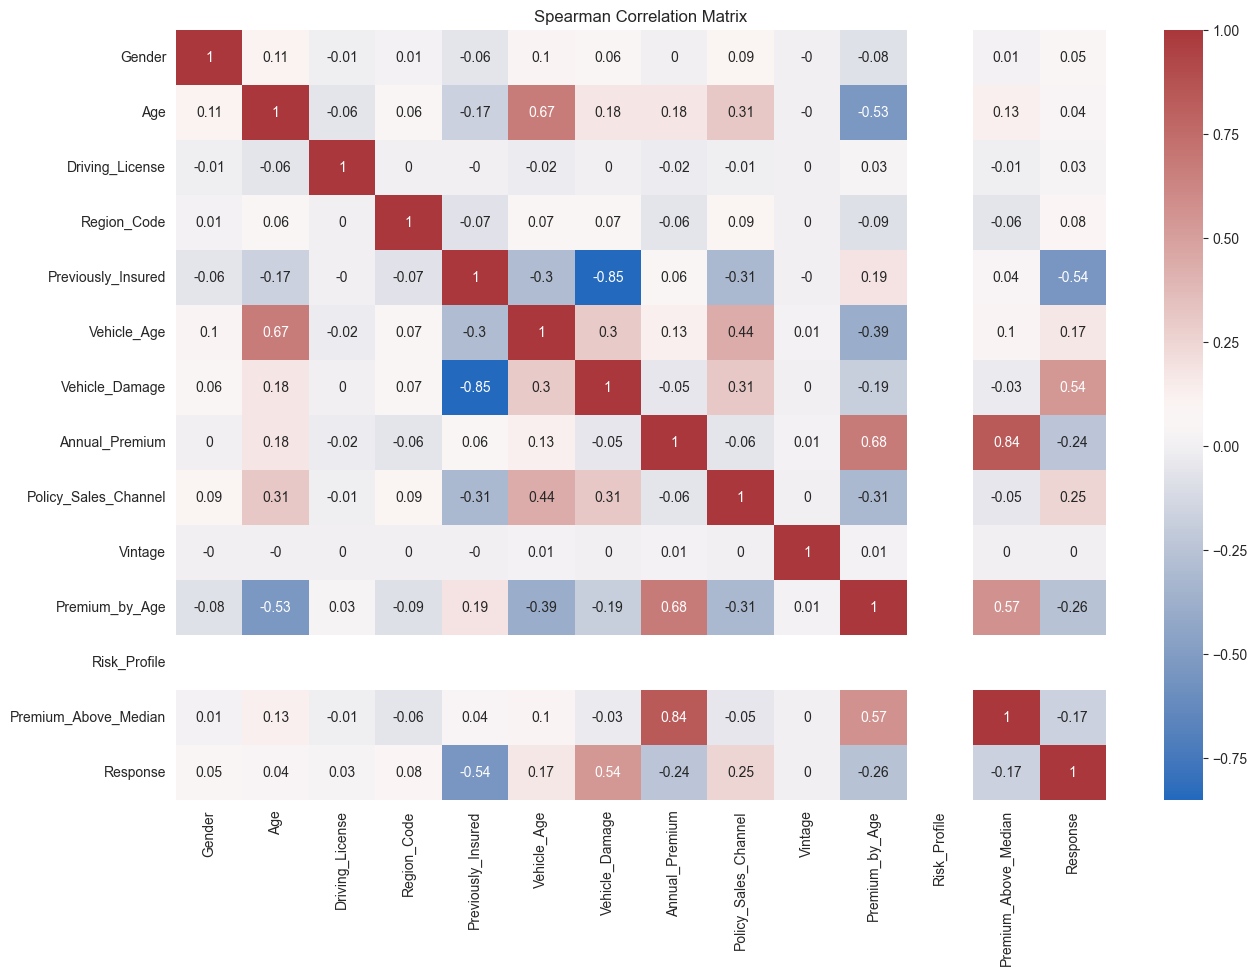

In [186]:
correlation_matrix = feature_selection.correlation("spearman")

From the Correlation Matrix above, it is possible to observe that there are variables with some mid level of correlation with the target `Response`, positively like `Vehicle_Damage` and `Policy_Sales_Channel`, and negatively `Previously_Insured`. 
<br><br>

There are **no variables that have a high correlation with our target**, which is nice. However, **there are features that have high correlation values between each other!**
<br><br>

This can introduce **Multicollinearity**, which can become to determine the individual effect of each variable on the target and severelly impact the model performance. Let's conduct a Variance Inlfation Factor (VIF) to measure how much multicollinearity exists.

 - VIF ≈ 1: No correlation between the feature and others.
 - 1 < VIF < 5: Moderate correlation, but not severe enough to cause concern.
 - VIF > 5 (and especially > 10): High multicollinearity, indicating a serious issue that should be addressed.


In [169]:
vif_data = feature_selection.calculate_variance_inflation_factor()

                 feature        VIF
0        Driving_License  71.616962
1         Premium_by_Age  40.123360
2         Annual_Premium  37.956636
3            Region_Code  31.193126
4                    Age  15.236155
5   Policy_Sales_Channel  15.010675
6         Vehicle_Damage  13.971821
7            Vehicle_Age   7.737627
8   Premium_Above_Median   4.915328
9     Previously_Insured   4.701757
10               Vintage   3.892897
11                Gender   2.445482
12          Risk_Profile        NaN


Features with High VIF:

- Driving_License (VIF = 22.28): This is extremely high. It suggests that Driving_License is highly correlated with one or more of the other features. This level of multicollinearity can make the coefficients in your model very unstable and unreliable.
- Region_Code (VIF = 9.65): This is also a high value, approaching the threshold of concern (VIF > 10). It indicates notable multicollinearity.
- Vehicle_Age (VIF = 7.70), Policy_Sales_Channel (VIF = 7.58), Age (VIF = 6.15), Vehicle_Damage (VIF = 6.44): These features also show some multicollinearity, though less severe than Driving_License and Region_Code.

**Let's explore other Feature Importance techniques to decide whether maintain or remove some of these variables**.
<br><br>
Some of the Feature Selection technniques include:

 - **VarianceThreshold:** To remove low-variance features.
 - **SelectKBest:** To select the top K features based on statistical tests (e.g., ANOVA, chi-square).
 - **RFE (Recursive Feature Elimination):** To recursively remove the least important features based on model performance.
 - **Model-Based Selection:** Use models like Random Forest or Gradient Boosting to rank features based on importance.

### Boruta Shap

**It is pretty slow, so all below was commented!**

Boruta is a robust method for feature selection, but it strongly relies on the calculation of the feature importances, which might be biased or not good enough for the data. [1](https://towardsdatascience.com/boruta-shap-an-amazing-tool-for-feature-selection-every-data-scientist-should-know-33a5f01285c0)

This is where SHAP joins the team. By using SHAP Values as the feature selection method in Boruta, we get the Boruta SHAP Feature Selection Algorithm. With this approach we can get the strong addictive feature explanations existent in SHAP method while having the robustness of Boruta algorithm to ensure only significant variables remain on the set.




### ShapRFECV - Recursive Feature Elimination using SHAP importance

Recursive Feature Elimination allows you to efficiently reduce the number of features in your dataset, without losing the predictive power of the model. probatus implements the following feature elimination routine for tree-based and linear models. [2](https://ing-bank.github.io/probatus/tutorials/nb_shap_feature_elimination.html#set-up-the-model-and-model-tuning)

The functionality is similar to RFECV, yet it removes the lowest importance features, based on SHAP features importance. The main advantages of using this routine are:

 - It uses a tree-based or a linear model to detect the complex relations between features and the target.
 - It uses SHAP importance, which is one of the most reliable ways to estimate features importance. Unlike many other techniques, it works with missing values and categorical variables.
 - Supports the use of sklearn compatible hyperparameter search schemas e.g. GridSearchCV, RandomizedSearchCV and BayesSearchCV, in order to optimize hyperparameters at each iteration. This way you can assess if the removal of a given feature reduces the predictive power, or simply requires additional tuning of the model.
 - You can also provide a list of features that should not be eliminated e.g. incase of prior knowledge.
 

 We need to set up the model that you would like to use in the feature elimination. probatus requires a **tree-based or linear binary classifier** in order to speed up the computation of SHAP feature importance at each step. We recommend using `LGBMClassifier`, which by default handles missing values and categorical features.

 By providing a list of columns to `columns_to_keep` parameter in the fit() function whe can say which features that should not be eliminated.

We can also use Early stopping in ShapRFECV. Early stopping is a way of mitigating overfitting in a relatively cheaply, without having to find the ideal regularization hyperparameters, wich can be accomplished by passing `early_stopping_rounds` to `ShapRFECV`. 

In [79]:
# shap_rfecv_model = XGBClassifier()
# shap_rfecv_features_keep = feature_selection.shap_rfecv(shap_rfecv_model, 0.2, 5, 
#                                                         'f1', 'f1', 7)
# shap_rfecv_features_keep

### Final Datasets

Let's drop the columns that were not significantly important to the model (whether froom VIF or other Feature Selection methods)

In [80]:
df_test_processed

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0.523077,1,0.181565,0,2,1,0.135041,0.179731,0.148789,1
1,0,0.092308,1,0.144837,0,1,1,0.031827,0.213321,0.934256,0
2,1,0.076923,1,0.160083,0,0,1,0.109563,0.200333,0.847751,0
3,1,0.138462,1,0.132874,0,1,1,0.000000,0.311274,0.778547,1
4,0,0.123077,1,0.186000,0,0,1,0.090865,0.236892,0.806228,1
...,...,...,...,...,...,...,...,...,...,...,...
76217,1,0.307692,1,0.187369,0,1,1,0.056028,0.240191,0.449827,0
76218,0,0.292308,1,0.085404,0,1,0,0.000000,0.183870,0.581315,0
76219,1,0.615385,1,0.207844,0,1,1,0.063875,0.170348,0.951557,0
76220,1,0.046154,1,0.066014,1,0,0,0.047699,0.028473,0.304498,0


In [81]:
df_train_und_processed

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0.155556,1,0.124650,0,0,1,0.042462,0.046422,0.625767,0
1,0,0.200000,1,0.157059,1,0,0,0.066531,0.707769,0.141104,0
2,0,0.266667,1,0.628650,0,0,1,0.054858,0.214867,0.110429,1
3,1,0.266667,1,0.091191,0,0,1,0.065263,0.052235,0.662577,0
4,0,0.177778,1,0.617737,0,0,1,0.085717,0.423380,0.684049,0
...,...,...,...,...,...,...,...,...,...,...,...
535033,1,0.344444,1,0.515755,0,1,1,0.000000,0.474050,0.628834,1
535034,1,0.300000,1,0.529424,0,0,1,0.076292,0.523548,0.033742,1
535035,1,0.344444,1,0.159757,0,1,1,0.000000,0.696832,0.177914,1
535036,1,0.188889,1,0.564344,0,0,1,0.081289,0.672712,0.174847,1


Since `Driving_License` has the highest VIF, and also doesn't show a significant correlation with the target `Response` (correlation=0.01), let's drop it from the datasets!

In [144]:
# Train dataset
df_train_features = df_train_und_processed.drop(columns=["Driving_License", "Response", "Vintage",
                                                         "Region_Code", "Policy_Sales_Channel"])
df_train_target = df_train_und_processed["Response"]

# Test dataset
df_test_features = df_test_processed.drop(columns=["Driving_License", "Response", "Vintage",
                                                   "Region_Code", "Policy_Sales_Channel"])
df_test_target = df_test_processed["Response"]

## **Modeling**

In [145]:
# Train dataset
y_train = df_train_target.to_numpy()
X_train = df_train_features.to_numpy()

# Test dataset
y_test = df_test_target.to_numpy()
X_test = df_test_features.to_numpy()

### Logistic Regression

`model.predict_proba(X_test)` returns a 2D array of shape `(n_samples, 2)`, where `n_samples` is the number of samples in `X_test`, and 2 represents the two classes (in a binary classification problem):

 - Column 0 contains the probabilities of each sample being in the negative class (class 0).
 - Column 1 contains the probabilities of each sample being in the positive class (class 1).

F1 Score: 0.38
Precision: 0.24
Recall: 0.97
Accuracy: 0.62
AUC: 0.80


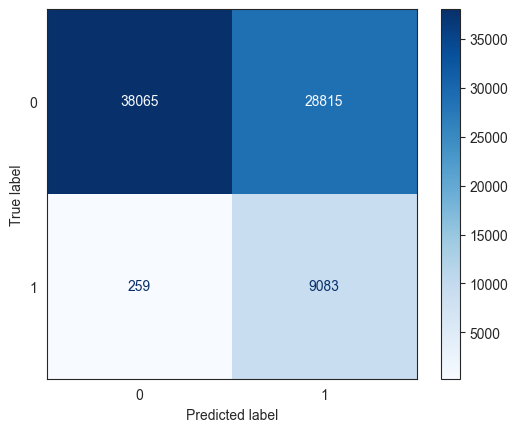

In [147]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
# [:, 1] to access positive class probabilities
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Calculating evaluation metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Printing the results
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc:.2f}')

cm_plot = ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test,
                                                display_labels=log_reg.classes_,
                                                cmap=plt.cm.Blues)

### XGBoost

F1 Score: 0.33
Precision: 0.20
Recall: 0.97
Accuracy: 0.53
AUC: 0.76


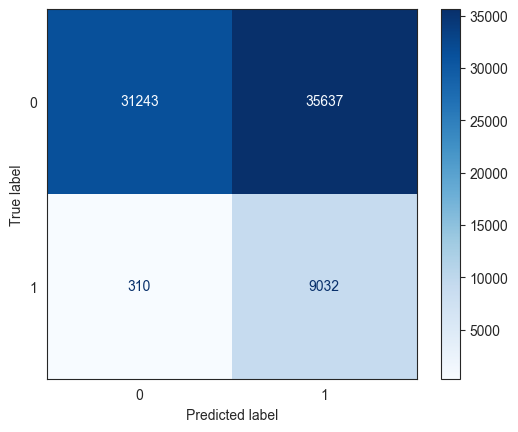

In [148]:
# "use_label_encoder" prevents a warning about using the label encoder
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# Predictions
y_pred = xgboost_model.predict(X_test)
# [:, 1] to access positive class probabilities
y_pred_proba = xgboost_model.predict_proba(X_test)[:, 1]

# Calculating evaluation metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Printing the results
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc:.2f}')

cm_plot = ConfusionMatrixDisplay.from_estimator(xgboost_model, X_test, y_test,
                                                display_labels=xgboost_model.classes_,
                                                cmap=plt.cm.Blues)